## Feature Engineering
Once the data has been profiled, with any obvious defects having been addressed, the next activity is to potentially enhance the data's ability to produce effective machine learning models. The single greatest opportunity for doing so involves techniques that are aimed at enhancing the patterns inherent (or hidden), within the sample data. For example, a sample may include a datetime feature. In their raw form, datetime features may show little correlation to other features or the target.  However, dataparts like Year, Month, DayOfWeek, HourOfDay and whether a particular day is a WeekDay, WeekEndDay, or a Holiday may show significant correlation. Therefore, in such a case it would be advantageous to "extract" that information from the raw DateTime feature.

#### Import Libraries

**Note:** Section **8.0. Extracting Features from Text Variables** uses the **NTLK** and **WordCloud** Python libraries. Before this section can be completed **the NTLK and Wordcloud libraries must first be installed** using one of the following commands in a Juptyer terminal: 
- If you're using Anaconda **conda install -c anaconda nltk** and **conda install -c anaconda wordcloud**
- Otherwise use: **python -m pip install nltk** and **python -m pip install wordcloud**

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import string
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.stem.snowball import SnowballStemmer

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, PowerTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import KBinsDiscretizer, PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, Normalizer
from sklearn.tree import DecisionTreeRegressor, export_graphviz

#### Define Global Functions

In [2]:
def double_plots(df, col):
    # function to plot a histogram and a Q-Q plot side by side, for a certain variable
    plt.figure(figsize=(10, 4.5))
    plt.subplot(1, 2, 1)
    df[col].hist(bins=30)
    plt.subplot(1, 2, 2)
    stats.probplot(df[col], dist="norm", plot=plt)
    plt.show()
    
def triple_plots(df, col):
    # function to plot a histogram, a Q-Q plot and a Boxplot side-by-side.
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    sns.distplot(df[col], bins=30)
    #sns.displot(data=df, x=df[col], kde=True)
    plt.title('Histogram')
    plt.subplot(1, 3, 2)
    stats.probplot(df[col], dist="norm", plot=plt)
    plt.ylabel(f"{col} quantiles")
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[col])
    plt.title('Boxplot')
    plt.show()
    
def before_and_after_plots(dfs, cols, titles):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))

    ax1.set_title(titles[0])
    for col in cols:
        sns.kdeplot(data=dfs[0][col], ax=ax1)

    ax2.set_title(titles[1])
    for col in cols:
        sns.kdeplot(data=dfs[1][col], ax=ax2)

    plt.show()
    
    
def side_by_side_tables(dfs:list, captions:list):
    """Display tables side by side to save vertical space"""
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

#### Import the Data 

In [3]:
data_dir = os.path.join(os.getcwd(), 'Data')
source_data_file = 'titanic-eda.csv';

data_file = os.path.join(data_dir, source_data_file)
df = pd.read_csv(data_file, header=0, index_col=0)

# Ensure the index values are: seed=1, increment=1
df.reset_index(drop=True, inplace=True)

print(f"Shape: {df.shape[0]} Observations x {df.shape[1]} Features")

Shape: 1307 Observations x 17 Features


#### Modify the Data Type of Categorical Features Having Numerical Values

In [4]:
df[['survived','sibsp','parch']] = df[['survived','sibsp','parch']].astype('object')
df.dtypes

age              float64
fare             float64
body             float64
cabin             object
embarked          object
home.dest         object
boat              object
cabin_NA            bool
embarked_NA         bool
boat_NA             bool
home.dest_NA        bool
survived          object
sex               object
sibsp             object
parch             object
ticket            object
survived_desc     object
dtype: object

#### Separate Numerical and Categorical Features

In [5]:
numerical_cols = [col for col in df.columns if df.dtypes[col] != 'O' and df.dtypes[col] != bool]
categorical_cols = [col for col in df.columns if col not in numerical_cols and df.dtypes[col] != bool]
cat_missing_cols = [col for col in df.columns if df.dtypes[col] == bool]

print(f"{df[numerical_cols].shape[1]} Numericals: {numerical_cols}") 
print(f"{df[categorical_cols].shape[1]} Categoricals: {categorical_cols}")
print(f"{len(cat_missing_cols)} Missing Value Indicators: {cat_missing_cols}")

3 Numericals: ['age', 'fare', 'body']
10 Categoricals: ['cabin', 'embarked', 'home.dest', 'boat', 'survived', 'sex', 'sibsp', 'parch', 'ticket', 'survived_desc']
4 Missing Value Indicators: ['cabin_NA', 'embarked_NA', 'boat_NA', 'home.dest_NA']


## Section I: Improving Existing Features

### 1.0 Handling Outliers
One outcome of data profiling is the identification of outliers. Before considering any further feature engineering activities it would be advantageous to consider how any outliers should be handled. Because parameters like mean, variance and standard deviation are all sensitive to outliers, some subsequent activities (e.g., scaling or transforming numericals) may be impacted by the current distribution of values in the affected features. Fundamentally, there are two approaches to handling outliers; exclusion (trimming) or engineering. The choice is primarily driven by whether or not those outliers represent erroneously entered values. If the values represent the general truth then it may not be advantageous to remove them.

Outliers can be engineered using a number of approaches. One way is to perform **variable discretization** whereby outliers will fall into the upper and/or lower categories. Another approach involves rendering outlying tuples as *null* so they will be treated as missing data when any imputation techniques are applied to handle missing data. Outliers can also be replaced by predetermined minimum and/or maximum values. Finally, in a process called **winsorization**, the mean and standard deviation, or the inter-quartile range or percentiles, can be used to treat parametric (normal) or non-paramtric (skewed) features.

##### First, Inspect the Distribution of the Variable In-Question

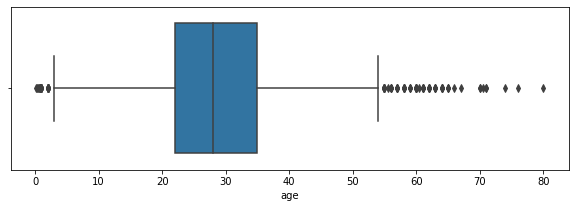

In [6]:
plt.figure(figsize=(10,3))
sns.boxplot(x=df.age)
plt.show()

#### 1.1. Trimming
Three techniques are available to determine the boundaries beyond which a value will be considered an outlier. First, when working with parametric (normally distributed) variables, the 3rd standard deviation (positive or negative) will encompass 99% of the sample; therefore, any values beyond those boundaries can be trimmed. Second, when working with either parametric or non-parametric variables, the inter-quartile range proximity rule can be used to define upper and lower boundaries. Finally, also applicable to both normal and non-normal variables, is arbitrarily setting the boundaries at the 5th and 95th quartiles.

##### 1.1.1. Using the Mean and (3rd) Standard Deviation

In [7]:
def std_bounds(df, col, distance):
    lbound = df[col].mean() - (df[col].std() * distance)
    ubound = df[col].mean() + (df[col].std() * distance)
    return ubound, lbound

In [8]:
df_copy = df[numerical_cols].copy()

age_ubound, age_lbound = std_bounds(df_copy, 'age', 1.5)
outliers_age = np.where(df_copy.age > age_ubound, True, np.where(df_copy.age < age_lbound, True, False))

df_trimmed = df_copy.loc[~outliers_age]
df_copy.shape, df_trimmed.shape

((1307, 3), (1102, 3))

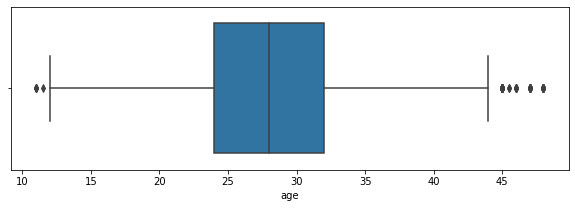

In [9]:
plt.figure(figsize=(10,3))
sns.boxplot(x=df_trimmed.age)
plt.show()

##### 1.1.2. Using the Inter-Quartile Proximity Rule

In [10]:
def iqr_bounds(df, col, distance):
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    lbound = df[col].quantile(0.25) - (IQR * distance)
    ubound = df[col].quantile(0.75) + (IQR * distance)
    return ubound, lbound

In [11]:
df_copy = df[numerical_cols].copy()

age_ubound, age_lbound = iqr_bounds(df_copy, 'age', 1.5)
outliers_age = np.where(df_copy.age > age_ubound, True, np.where(df_copy.age < age_lbound, True, False))

df_trimmed = df_copy.loc[~outliers_age]
df_copy.shape, df_trimmed.shape

((1307, 3), (1206, 3))

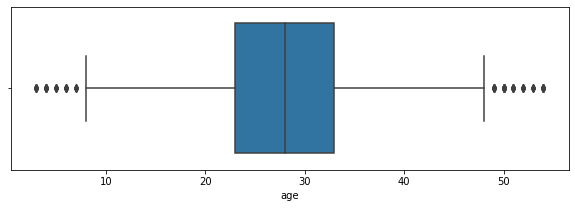

In [12]:
plt.figure(figsize=(10,3))
sns.boxplot(x=df_trimmed.age)
plt.show()

##### 1.1.3. Using the 5th and 95th Quartiles

In [13]:
def arb_bounds(df, col):
    lbound = df[col].quantile(0.05)
    ubound = df[col].quantile(0.95)
    return ubound, lbound

In [14]:
df_copy = df[numerical_cols].copy()

age_ubound, age_lbound = arb_bounds(df_copy, 'age')
outliers_age = np.where(df_copy.age > age_ubound, True, np.where(df_copy.age < age_lbound, True, False))

df_trimmed = df_copy.loc[~outliers_age]
df_copy.shape, df_trimmed.shape

((1307, 3), (1182, 3))

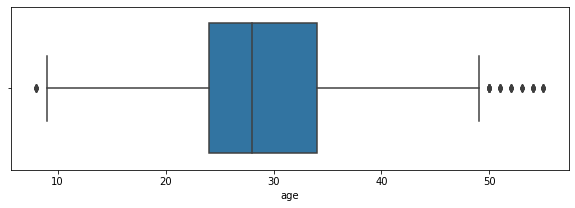

In [15]:
plt.figure(figsize=(10,3))
sns.boxplot(x=df_trimmed.age)
plt.show()

#### 1.2. Winsorization

In [16]:
def winsorize(df, col, ubound, lbound):
    return np.where(df[col] > ubound, ubound, np.where(df[col] < lbound, lbound, df[col]))

In [17]:
df_copy = df[numerical_cols].copy()
df_copy['age'] = winsorize(df_copy, 'age', df_copy.age.quantile(0.95), df_copy.age.quantile(0.05))

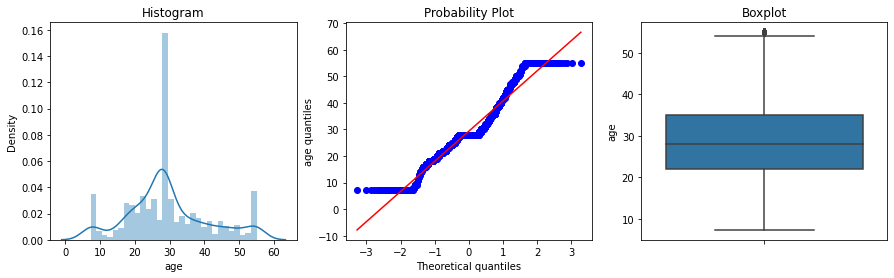

In [18]:
triple_plots(df_copy, 'age')

#### 1.3. Capping at Arbitrary Maximum and Minimum Values

In [19]:
def skewed_bounds(df, col, distance):
    # Use the IRQ Proximity Rule for Non-Parametric features
    ubound, lbound = iqr_bounds(df, col, distance)

    return ubound, lbound

def normal_bounds(df, col, distance):
    # Use Mean & Std for Parametric features
    ubound, lbound = std_bounds(df, col, distance)

    return ubound, lbound

In [20]:
df_copy = df[numerical_cols].copy()

age_ubound, age_lbound = skewed_bounds(df_copy, 'age', 3)

df_copy['age'] = np.where(df_copy['age'] > age_ubound, age_ubound,
                       np.where(df_copy['age'] < age_lbound, age_lbound, df_copy['age']))

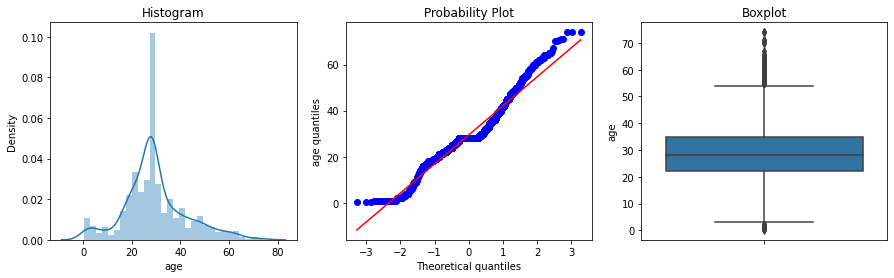

In [21]:
triple_plots(df_copy, 'age')

#### 1.4 Zero-coding: Capping Values at Zero

In [22]:
def zero_bound(df, col):
    return np.where(df[col] < 0, True, False)

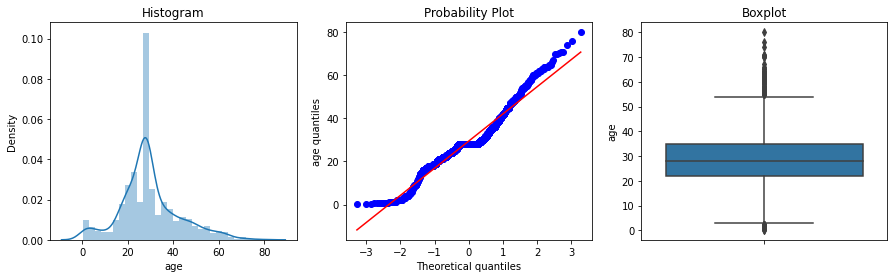

In [23]:
df_copy = df[numerical_cols].copy()

outliers_age = zero_bound(df_copy, 'age')
df_trimmed = df_copy.loc[~outliers_age]

triple_plots(df_trimmed, 'age')

### 2.0 Scaling Numerical Features
Numerical features (variables) are those datum having continuous numeric values (e.g., float or decimal types).  As such, each numerical feature is likely to exhibit an unique range of values that may or may not contain both positive and negative values. Some machine learning algorithms are better equipt to cope with multiple features having different ranges than are others.  It is customary, if not altogether necessary, to transform each numerical feature in a collection of independent features so that they conform to a predetermined range (e.g., between 0 and 1, or having a mean of 0 (zero) and a standard deviation of 1 (one)).

#### 2.1 Standardization
Standardization transforms the values of a numerical feature so they have a mean of 0 (zero) and a standard deviation of 1 (one).

##### Using Scikit-Learn

In [24]:
df_copy = df[numerical_cols].copy()

scaler = StandardScaler()
scaler.fit(df_copy)
arr_scaled = scaler.transform(df_copy)

print(f"Mean of the Features: {scaler.mean_ }")
print(f"Standard Deviation of the Features: {scaler.scale_}")

df_scaled = pd.DataFrame(arr_scaled, columns=df_copy.columns)

Mean of the Features: [ 29.49171132  33.33442229 160.80889497]
Standard Deviation of the Features: [12.903941   51.7490731  29.60288931]


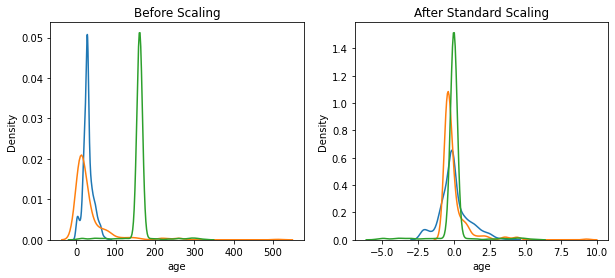

In [25]:
dfs = [df_copy, df_scaled]
columns = ['age','fare','body']
titles = ['Before Scaling','After Standard Scaling']

before_and_after_plots(dfs, columns, titles)

#### 2.2 Mean Normalization
Mean normalization centers the feature at 0 (zero), and re-scales to the value range. The formula subtracts the mean of each observation and divides by the difference between the minimum and maximum value: **X_scaled = (X - X.mean) / (X.max - X.min)**

##### Using Pandas

In [26]:
df_copy = df[numerical_cols].copy()

means = df_copy.mean(axis=0)
ranges = df_copy.max(axis=0)-df_copy.min(axis=0)

df_scaled = (df_copy - means)/ranges

##### Using Scikit-Learn

In [27]:
scaler_mean = StandardScaler(with_mean=True, with_std=False)
scaler_mean.fit(df_copy)
scaler_minmax = RobustScaler(with_centering=False, with_scaling=True, quantile_range=(0,100))
scaler_minmax.fit(df_copy)

arr_normed = scaler_minmax.transform(scaler_mean.transform(df_copy))
df_normed = pd.DataFrame(data=arr_normed, columns=df_copy.columns)

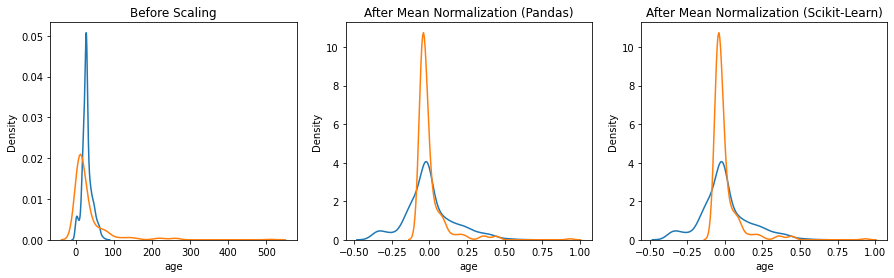

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15,4))

ax1.set_title("Before Scaling")
sns.kdeplot(data=df_copy.age, ax=ax1)
sns.kdeplot(data=df_copy.fare, ax=ax1)

ax2.set_title("After Mean Normalization (Pandas)")
sns.kdeplot(data=df_scaled.age, ax=ax2)
sns.kdeplot(data=df_scaled.fare, ax=ax2)

ax3.set_title("After Mean Normalization (Scikit-Learn)")
sns.kdeplot(data=df_normed.age, ax=ax3)
sns.kdeplot(data=df_normed.fare, ax=ax3)

plt.show()

#### 2.3 MinMax Scaling
Minimum and Maximum Scaling compresses all values in the distribution between 0 (zero) and 1 (one). The formula subracts the the minimum value from all the observation, and then divides it by the value range: **X_scaled = (X - X.min / (X.max - X.min))**.

##### Using Scikit-Learn

In [29]:
df_copy = df[numerical_cols].copy()

scaler = MinMaxScaler()
scaler.fit(df_copy)
arr_scaled = scaler.transform(df_copy)

print(f"Maximum of the Features: {scaler.data_max_}")
print(f"Minumum of the Features: {scaler.min_}")
print(f"Data Range: {scaler.data_range_}")

df_scaled = pd.DataFrame(arr_scaled, columns=df_copy.columns)

Maximum of the Features: [ 80.     512.3292 328.    ]
Minumum of the Features: [-0.0020881  0.        -0.0030581]
Data Range: [ 79.8333 512.3292 327.    ]


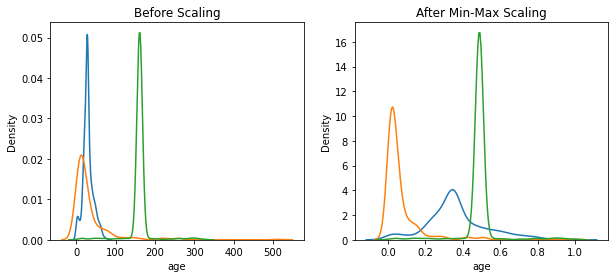

In [30]:
dfs = [df_copy, df_scaled]
columns = ['age','fare','body']
titles = ['Before Scaling','After Min-Max Scaling']

before_and_after_plots(dfs, columns, titles)

#### 2.4.1. Maximum Absolute Scaling
Maximum absolute scaling scales the data to its maximum value: **X_scaled = X / X.max**

In [31]:
df_copy = df[numerical_cols].copy()

scaler = MaxAbsScaler()
scaler.fit(df_copy)
arr_scaled = scaler.transform(df_copy)

print(f"Absolute Maximum of the Features: {scaler.max_abs_}")

df_scaled = pd.DataFrame(arr_scaled, columns=df_copy.columns)

Absolute Maximum of the Features: [ 80.     512.3292 328.    ]


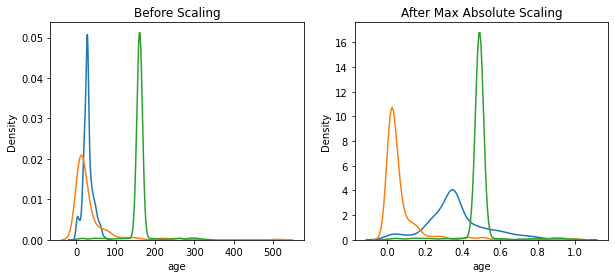

In [32]:
dfs = [df_copy, df_scaled]
columns = ['age','fare','body']
titles = ['Before Scaling','After Max Absolute Scaling']

before_and_after_plots(dfs, columns, titles)

#### 2.4.2. Centering + MaxAbsScaling
Distributions can be centered at 0 (zero) before being scaled to its absolute maximum.

In [33]:
df_copy = df[numerical_cols].copy()

scaler_mean = StandardScaler(with_mean=True, with_std=False)
scaler_maxabs = MaxAbsScaler()

scaler_mean.fit(df_copy)
scaler_maxabs.fit(df_copy)

arr_scaled = scaler_maxabs.transform(scaler_mean.transform(df_copy))

df_scaled = pd.DataFrame(arr_scaled, columns=df_copy.columns)

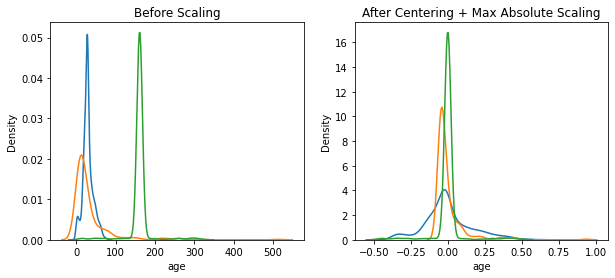

In [34]:
dfs = [df_copy, df_scaled]
columns = ['age','fare','body']
titles = ['Before Scaling','After Centering + Max Absolute Scaling']

before_and_after_plots(dfs, columns, titles)

#### 2.5 Robust Scaling (Scaling with the Median and Quantiles)
Robust scaling produces more robust estimates for the center and value range of the feature, and is less sensitive to outliers. This is achieved by scaling variables to the median and quantiles (i.e., the median value is removed from the sample and the result is divided by the inter-quartile range (IQR)).

In [35]:
df_copy = df[numerical_cols].copy()

scaler = RobustScaler()
scaler.fit(df_copy)
arr_scaled = scaler.transform(df_copy)

print(f"Median Values: {scaler.center_}")
print(f"IQR Values of the Features: {scaler.scale_}")

df_scaled = pd.DataFrame(arr_scaled, columns=df_copy.columns)

Median Values: [ 28.          14.4542     160.82385071]
IQR Values of the Features: [1.30000000e+01 2.33792000e+01 2.28565073e-02]


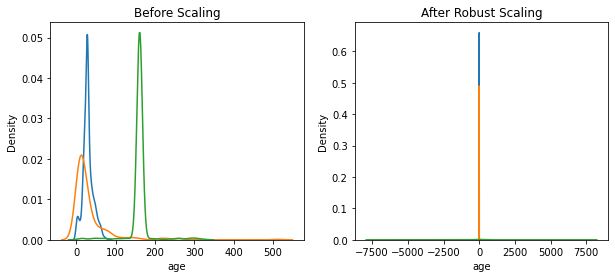

In [36]:
dfs = [df_copy, df_scaled]
columns = ['age','fare','body']
titles = ['Before Scaling','After Robust Scaling']

before_and_after_plots(dfs, columns, titles)

#### 2.6. Scaling to Vector Unit Length
When scaling to vector unit length, the components of a feature vector are transformed so that the transformed vector has a length of 1 (i.e., a norm of 1). This scaling technique scales the feature vector, rather than each individual variable. A feature vector contains the values of each variable for a single observation. When scaling to vector unit length, we divide each feature vector by its norm.

Scaling to the unit norm is achieved by dividing each observation vector by either the Manhattan distance (l1 norm) or the Euclidean distance (l2 norm).
- The Manhattan distance is given by the sum of the absolute components of the vector: **l1(X) = |x1| + |x2| + ... + |xn|**
- Whereas the Euclidean distance is given by the square root of the square sum of the component of the vector: **l2(X) = sqr( x1^2 + x2^2 + ... + xn^2 )**

#### 2.6.1. Scaling to I1

In [37]:
df_copy = df[numerical_cols].copy()

scaler = Normalizer(norm='l1')
scaler.fit(df_copy)

arr_scaled = scaler.transform(df_copy)

##### Calculate the l1 Norm for each Observation: Original Data

In [38]:
np.round(np.linalg.norm(df_copy, ord=1, axis=1), 1)

array([401. , 313.2, 314.3, ..., 337.7, 195.1, 197.7])

##### Calculate the l1 Norm for each Observation: Scaled Data

In [39]:
np.round(np.linalg.norm(arr_scaled, ord=1, axis=1), 1)

array([1., 1., 1., ..., 1., 1., 1.])

##### 2.6.2. Scaling to I2

In [40]:
df_copy = df[numerical_cols].copy()

scaler = Normalizer(norm='l2')
scaler.fit(df_copy)

arr_scaled = scaler.transform(df_copy)

##### Calculate the l2 Norm for each Observation: Original Data

In [41]:
np.round(np.linalg.norm(df_copy, ord=1, axis=1), 1)

array([401. , 313.2, 314.3, ..., 337.7, 195.1, 197.7])

##### Calculate the l2 Norm for each Observation: Scaled Data

In [42]:
np.round(np.linalg.norm(arr_scaled, ord=1, axis=1), 1)

array([1.5, 1.4, 1.4, ..., 1.1, 1.2, 1.2])

### 3.0. Transforming Numerical Features
A number of machine learning algorithms, like Logistic Regression (for classification) and Linear Regression, assume that the features are parametric (normally distributed); however, source data may not satisfy this assumption. Fortunately there are a number of mathematical transformations that can be used to engineer non-parametric features to conform to a parametric (normal or gaussian) distribution. What's more, these transformations often reveal linear relationships that may exist between those predictors (independent variables) and the response (dependend variable or Target). Ergo, these transformations may improve the efficacy of the resulting model. Among these mathematical transformations are the logarithm, reciprocal, power, square and cube root, Box-Cox, and Yeo-Johnson transformations. It is important to note that these tranformations should be applied to complete data; i.e., any missing data should have already either been excluded or imputed.

##### Ensure there are no missing values

In [43]:
df[numerical_cols].isnull().sum().sort_values(ascending=True)

age     0
fare    0
body    0
dtype: int64

##### Inspect the Distribution Before Transformation:

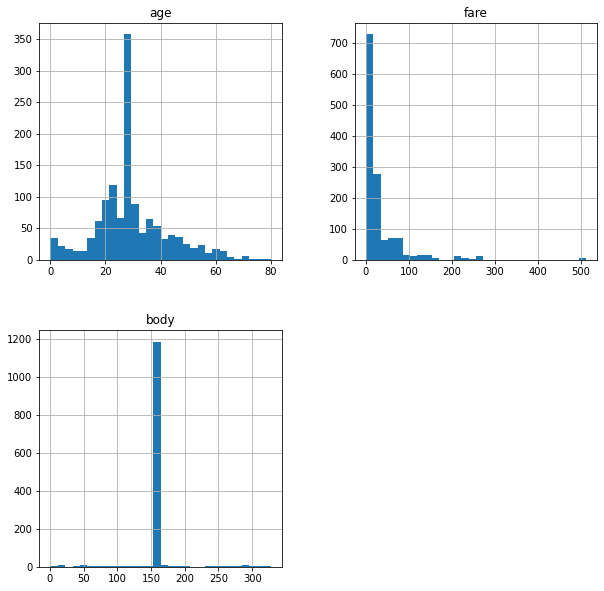

In [44]:
df[numerical_cols].hist(bins=30, figsize=(10,10))
plt.show()

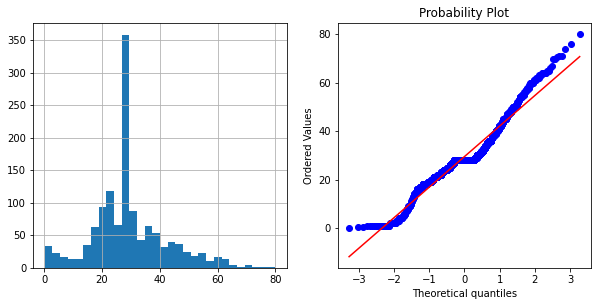

In [45]:
double_plots(df, 'age')

#### 3.1 Logarithmic Transformation
##### Using NumPy

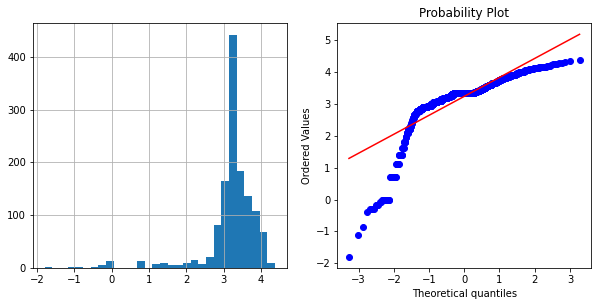

In [46]:
df_copy = df[numerical_cols].copy()
df_copy['age'] = np.log(df_copy.age)

double_plots(df_copy, 'age')

##### Using Scikit-Learn

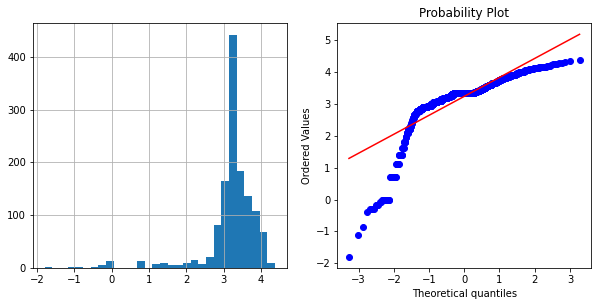

In [47]:
df_copy = df[numerical_cols].copy()

transformer = FunctionTransformer(np.log, validate=True)
df_trn = transformer.transform(df_copy)
df_trn = pd.DataFrame(df_trn, columns=numerical_cols)

double_plots(df_trn, 'age')

#### 3.2. Reciprocal Transformation
##### Using NumPy

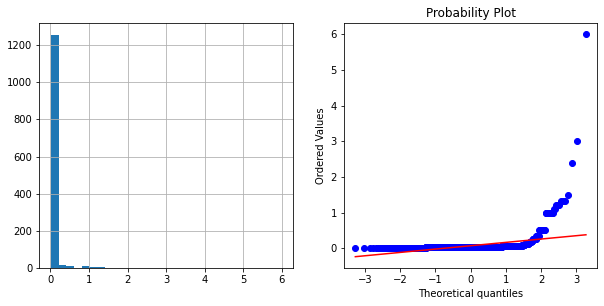

In [48]:
df_copy = df[numerical_cols].copy()
df_copy['age'] = np.reciprocal(df_copy.age)

double_plots(df_copy, 'age')

##### Using Scikit-Learn

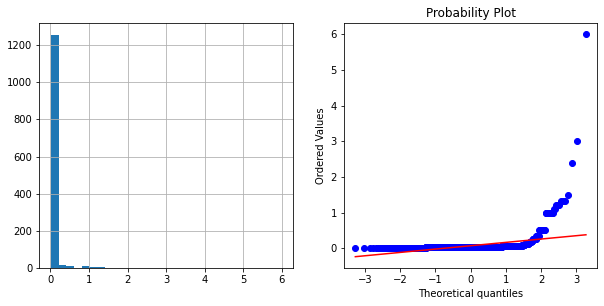

In [49]:
df_copy = df[numerical_cols].copy()

transformer = FunctionTransformer(np.reciprocal, validate=True)
df_trn = transformer.transform(df_copy)
df_trn = pd.DataFrame(df_trn, columns=numerical_cols)

double_plots(df_trn, 'age')

#### 3.3. Square/Cube Root Transformation
##### Using NumPy

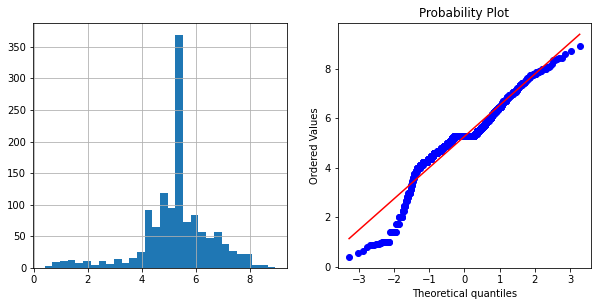

In [50]:
df_copy = df[numerical_cols].copy()
df_copy['age'] = np.sqrt(df_copy.age)

double_plots(df_copy, 'age')

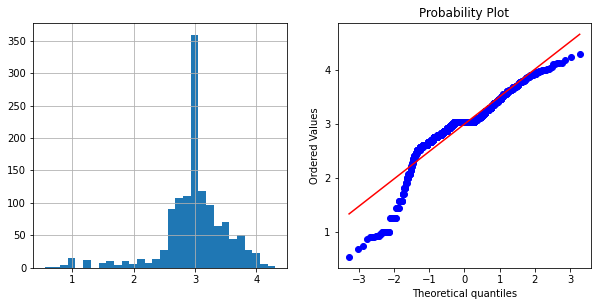

In [51]:
df_copy = df[numerical_cols].copy()
df_copy['age'] = np.cbrt(df_copy.age)

double_plots(df_copy, 'age')

##### Using Scikit-Learn

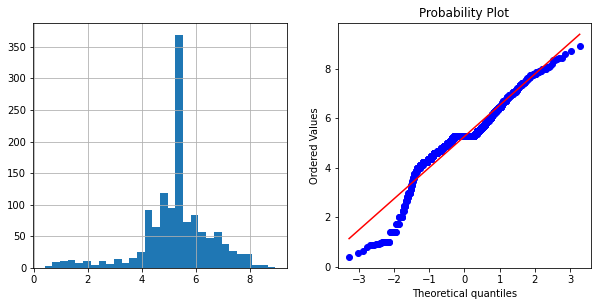

In [52]:
df_copy = df[numerical_cols].copy()

transformer = FunctionTransformer(np.sqrt, validate=True)
df_trn = transformer.transform(df_copy)
df_trn = pd.DataFrame(df_trn, columns=numerical_cols)

double_plots(df_trn, 'age')

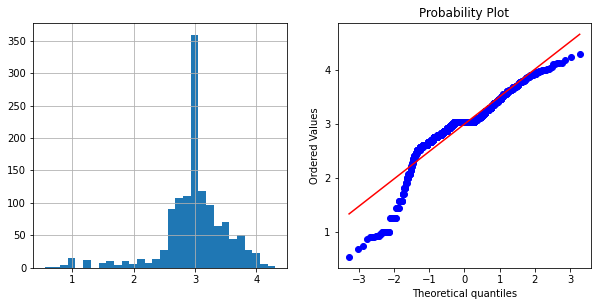

In [53]:
df_copy = df[numerical_cols].copy()

transformer = FunctionTransformer(np.cbrt, validate=True)
df_trn = transformer.transform(df_copy)
df_trn = pd.DataFrame(df_trn, columns=numerical_cols)

double_plots(df_trn, 'age')

#### 3.4. Power (Exponential) Transformation
##### Using NumPy

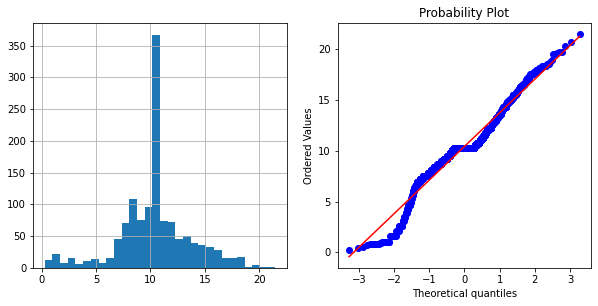

In [54]:
df_copy = df[numerical_cols].copy()
df_copy['age'] = np.power(df_copy.age, 0.7)

double_plots(df_copy, 'age')

##### Using Scikit-Learn

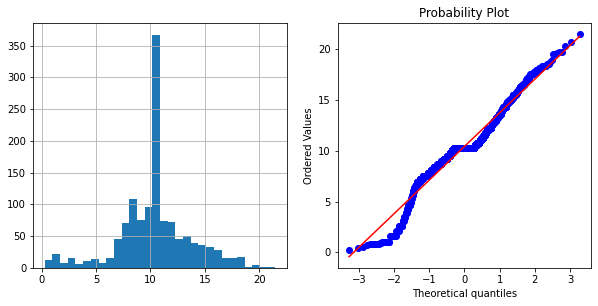

In [55]:
df_copy = df[numerical_cols].copy()

transformer = FunctionTransformer(lambda x: np.power(x, 0.7), validate=True)
df_trn = transformer.transform(df_copy)
df_trn = pd.DataFrame(df_trn, columns=numerical_cols)

double_plots(df_trn, 'age')

#### 3.5. Box-Cox Transformation
##### Using SciPy

Optimal Lambda:  0.7870405436135359


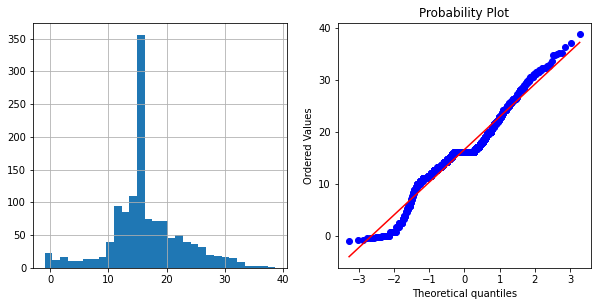

In [56]:
df_copy = df[numerical_cols].copy()
df_copy['age'], param = stats.boxcox(df_copy.age)

print('Optimal Lambda: ', param)
double_plots(df_copy, 'age')

##### Using Scikit-Learn

In [57]:
#df_copy = df[numerical_cols].copy()

#transformer = PowerTransformer(method='box-cox', standardize=True)
#transformer.fit(df_copy)

#df_trn = transformer.transform(df_copy)
#df_trn = pd.DataFrame(df_trn, columns=numerical_cols)

#print(f"Lambdas: {transformer.lambdas_}")
#double_plots(df_trn, 'age')

#### 3.6. Yeo-Johnson Transformation
##### Using SciPy

Optimal Lambda:  0.7785774167890672


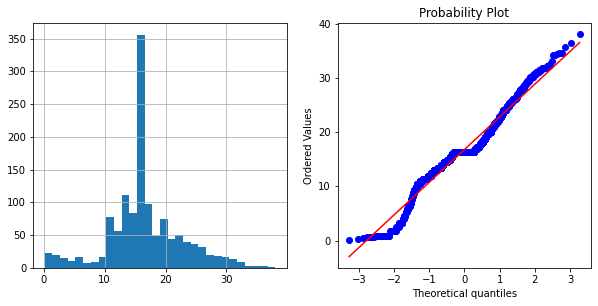

In [58]:
df_copy = df[numerical_cols].copy()
df_copy['age'], param = stats.yeojohnson(df_copy.age)

print('Optimal Lambda: ', param)
double_plots(df_copy, 'age')

##### Using Scikit-Learn

Lambdas: [ 0.77857742 -0.14030257  1.15872008]


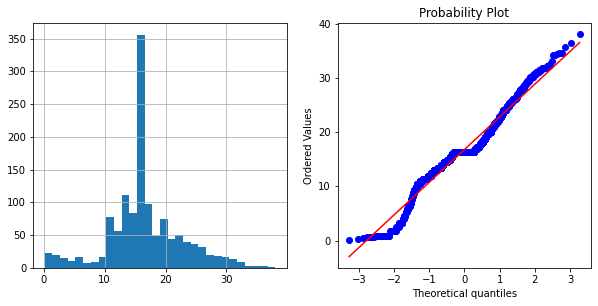

In [59]:
df_copy = df[numerical_cols].copy()

transformer = PowerTransformer(method='yeo-johnson', standardize=False)
transformer.fit(df_copy)

df_trn = transformer.transform(df_copy)
df_trn = pd.DataFrame(df_trn, columns=numerical_cols)

print(f"Lambdas: {transformer.lambdas_}")
double_plots(df_trn, 'age')

### 4.0. Encoding Categorical Features
Categorical features (variables) are those datum having discrete values (rather than contiunous numerical values) where each unique value represents some member or level of the specified category. What's more, categorical features may reflect datum having a natural order (e.g., Size: Small, Medium or Large), or may exhibit no such natural ordering (e.g., Fruit: Apple, Orange, or Banana).  The former are designated **Ordinal** Categorical Variables whereas the latter are designated **Nominal** Categorical Variables. In any case, machine learning algorithms aren't typically well equipt to cope with text-based labels; therefore, it is both customary and necessary to translate these text-based labels into some form of numerical representation in order for machine learning algorithms to learn from them effectively.
#### 4.1. One-Hot Encoding
Sometimes called "dummy encoding", one-hot encoding is most appropriate for representing **nominal** categorical features because it is unable to denote any ordering of the values it represents. One-hot encoding transforms a categorical variable by creating a new group of binary variables where each member in the group represents each unique value (category) contained in the original variable. For each observation, only one of the new variables will contain the value 1 (one) as it corresponds to the value present in that observation while all other variables in the group will contain the value 0 (zero) to signify the absense of that value in the observation; hence, one is **"hot"** while the others are **not**.  For example, if a feature (variable) named "Color" contains the values "Red", "Green" and "Blue", then one-hot encoding would create three new features named "Red", "Green" and "Blue". Subsequently, where in a specific observation the feature named "Color" contains the value "Green", the new varable named "Green" would contain the value 1 (one) while the new variables named "Red" and "Blue" would both contain the value 0 (zero).

##### 4.1.1. One-Hot Encoding Using Pandas

In [60]:
df.sex.unique()

array(['female', 'male'], dtype=object)

In [61]:
ohe_sex = pd.get_dummies(df.sex, drop_first=False)
ohe_sex.head()

,female,male
0,1,0
1,0,1
2,1,0
3,0,1
4,1,0


##### Alternate: k-1 One-Hot Encoding
For the sake of reducing the dimensionality of the newly created group of binary variables, a categorical variable with *k* unique categories can be encoded using *k-1* binary variables. Extending our "Color" example, it is possible to accurately represent this feature using only 2 binary variables (e.g., Green and Blue). If the feature contained the value "Green" then the variable "Green" would be 1 (one) with the variable "Blue" being 0 (zero). If the feature contained the value "Blue" then the reverse would be true.  However, if the feature contained the value "Red" then both "Green" and "Blue" would contain the value 0 (zero).

In [62]:
k1_ohe_sex = pd.get_dummies(df.sex, drop_first=True)
k1_ohe_sex.head()

,male
0,0
1,1
2,0
3,1
4,0


##### 4.1.2. One-Hot Encoding Using Scikit-Learn

In [63]:
cats = df[categorical_cols].drop(['ticket'], axis=1)
cats.nunique()

cabin            181
embarked           3
home.dest        369
boat              28
survived           2
sex                2
sibsp              7
parch              8
survived_desc      2
dtype: int64

In [64]:
oh_encoder = OneHotEncoder(categories='auto', sparse=False) # returns k dummies.
oh_encoder.fit(cats)

ohe_cats = oh_encoder.transform(cats)

In [65]:
pd.DataFrame(ohe_cats).head()

,0,1,2,3,4,5,6,7,8,9,...,592,593,594,595,596,597,598,599,600,601
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


##### Alternate: k-1 One-Hot Encoding

In [66]:
k1_oh_encoder = OneHotEncoder(categories='auto', sparse=False, drop='first') # returns k-1 dummies.
k1_oh_encoder.fit(cats)

k1_ohe_cats = k1_oh_encoder.transform(cats)

In [67]:
pd.DataFrame(k1_ohe_cats).head()

,0,1,2,3,4,5,6,7,8,9,...,583,584,585,586,587,588,589,590,591,592
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


##### 4.1.3. One-Hot Encoding of Most Frequent Categories
Since One-Hot Encoding represents each category that's contained by a categorical feature as a new feature, this encoding technique can quickly expand the dimensionality (i.e., the number of features) of a dataset if the feature being encoded is highly cardinal (i.e., has many unique values). This issue can be addressed by selectively discretizing those categories (values). The most frequently occurring categories can be represented by unique binary features per the customary one-hot encoding technique while those categories having few occurances can be grouped into a smaller number of additional binary features where each feature represents some logical range of values.

##### First, Determine the Cardinality of the Feature, and then Inspect its Value Distribution

In [68]:
feature = 'home.dest'

df[feature].nunique()

369

In [69]:
df[feature].value_counts().sort_values(ascending=False)

New York, NY                                  627
London                                         14
Montreal, PQ                                   10
Paris, France                                   9
Cornwall / Akron, OH                            9
                                             ... 
St Denys, Southampton, Hants                    1
London Brooklyn, NY                             1
Kilmacowen, Co Sligo, Ireland New York, NY      1
Brighton, MA                                    1
Belmont, MA                                     1
Name: home.dest, Length: 369, dtype: int64

##### Next, Create a List Containing its Top 'n' Categories, and Use it to Create a Binary Variable for Each Category

In [70]:
n = 3

top_n = [x for x in df[feature].value_counts().sort_values(ascending=False).head(n).index]
top_n

['New York, NY', 'London', 'Montreal, PQ']

In [71]:
for label in top_n:
    df[feature + '_' + label] = np.where(df[feature] == label, 1, 0)
    
df[[feature] + [feature + '_' + c for c in top_n]].head(6)

,home.dest,"home.dest_New York, NY",home.dest_London,"home.dest_Montreal, PQ"
0,"St Louis, MO",0,0,0
1,"Montreal, PQ / Chesterville, ON",0,0,0
2,"Montreal, PQ / Chesterville, ON",0,0,0
3,"Montreal, PQ / Chesterville, ON",0,0,0
4,"Montreal, PQ / Chesterville, ON",0,0,0
5,"New York, NY",1,0,0


#### 4.2. Ordinal Encoding
This technique simply replaces each category with an arbitrarily assigned integer value falling in the range 1 to *k* (or 0 to *k*-1) where *k* is equal to the number of unique categories. Ordinal encoding is well suited fro non-linear machine learning algorithms due to their ability to traverse arbitrarily-assigned digits in search of patterns relating to the *Target*.
##### Using Pandas

In [72]:
column = 'boat'
column_enc = 'boat_ord'

df_copy = df[categorical_cols].copy()

def ordinal_mappings(df, feature):
    return {k: i for i, k in enumerate(df[feature].unique(), 0)}

def ordinal_encode(df, feature, mapping):
    return df[feature].map(mapping)

ord_map = ordinal_mappings(df_copy, column)
display(ord_map)

{'2': 0,
 '11': 1,
 'unknown': 2,
 '3': 3,
 '10': 4,
 'D': 5,
 '4': 6,
 '9': 7,
 '6': 8,
 'B': 9,
 '8': 10,
 'A': 11,
 '5': 12,
 '7': 13,
 'C': 14,
 '14': 15,
 '5 9': 16,
 '13': 17,
 '1': 18,
 '15': 19,
 '5 7': 20,
 '8 10': 21,
 '12': 22,
 '16': 23,
 '13 15 B': 24,
 'C D': 25,
 '15 16': 26,
 '13 15': 27}

In [73]:
df_copy[column_enc] = ordinal_encode(df_copy, column, ord_map)
df_copy[[column, column_enc]].head()

,boat,boat_ord
0,2,0
1,11,1
2,unknown,2
3,unknown,2
4,unknown,2


##### Using Scikit-Learn

In [74]:
cats = ['cabin','home.dest','boat']
df_cats = df[cats]
df_cats.nunique()

cabin        181
home.dest    369
boat          28
dtype: int64

In [75]:
ord_encoder = OrdinalEncoder()
ord_encoder.fit(df_cats)

ord_encoder.categories_

[array(['A10', 'A11', 'A14', 'A16', 'A18', 'A19', 'A20', 'A21', 'A23',
        'A24', 'A26', 'A29', 'A31', 'A32', 'A34', 'A36', 'A5', 'A6', 'A7',
        'A9', 'B10', 'B101', 'B102', 'B11', 'B18', 'B19', 'B20', 'B22',
        'B24', 'B26', 'B28', 'B3', 'B30', 'B35', 'B36', 'B37', 'B38',
        'B39', 'B4', 'B41', 'B42', 'B45', 'B49', 'B5', 'B50', 'B51', 'B52',
        'B57', 'B58', 'B61', 'B69', 'B71', 'B73', 'B77', 'B78', 'B79',
        'B80', 'B82', 'B86', 'B94', 'B96', 'C101', 'C103', 'C104', 'C105',
        'C106', 'C110', 'C111', 'C116', 'C118', 'C123', 'C124', 'C125',
        'C126', 'C128', 'C130', 'C132', 'C148', 'C2', 'C22', 'C23', 'C28',
        'C30', 'C31', 'C32', 'C39', 'C45', 'C46', 'C47', 'C49', 'C50',
        'C51', 'C52', 'C53', 'C54', 'C55', 'C6', 'C62', 'C65', 'C68', 'C7',
        'C70', 'C78', 'C80', 'C82', 'C83', 'C85', 'C86', 'C87', 'C89',
        'C90', 'C91', 'C92', 'C93', 'C95', 'C97', 'C99', 'D', 'D10', 'D11',
        'D15', 'D17', 'D19', 'D20', 'D21', 'D22',

In [76]:
ord_cats = ord_encoder.transform(df_cats)

pd.DataFrame(ord_cats, columns=cats).head()

,cabin,home.dest,boat
0,43.0,308.0,11.0
1,79.0,230.0,2.0
2,79.0,230.0,27.0
3,79.0,230.0,27.0
4,79.0,230.0,27.0


#### 4.3 Count Encoding or Frequency Encoding
These encoding techniques add weighting to the **value** used to encode a categorical feature by replacing each category with either its count or the percentage (frequency) of observations it represents within that features distribution.  For example, consider a sample having 100 observations that contains a categorical feature named **Color** which contains 20 Red, 50 Green, and 30 Blue categories. Frequency Encoding would replace Red observations with 0.2, Green with 0.5, and Blue with 0.3.  Count Encoding with replace Red with 20, Green with 50, and Blue with 30. The motivation for this technique is that the proportion of each category contributes significantly towards predicting the *Target*.

##### 4.3.1. Count Encoding
##### First, Create a Dictionary to Capture the Count of Observations per Category

In [77]:
column = 'parch'
df_copy = df[categorical_cols].copy()

count_map = df_copy[column].value_counts().to_dict()
count_map

{0: 1000, 1: 170, 2: 113, 3: 8, 4: 6, 5: 6, 6: 2, 9: 2}

##### Next, Replace Each Category with the Count of its Observations

In [78]:
col_enc = 'parch_enc'
df_copy[col_enc] = df[column].map(count_map)

df_copy[[column, col_enc]].head()

,parch,parch_enc
0,0,1000
1,2,113
2,2,113
3,2,113
4,2,113


##### 4.3.2. Fequency Encoding
Frequency encoding is achieved simply by dividing the value count by the total number (count) of observations. Here the algorithm will be codified into two functions; one to create the mapping, and one to create the encoded feature.

In [79]:
df_copy = df[categorical_cols].copy()

col_name = 'parch'
enc_col_name = 'parch_freq'

def frequency_mappings(df, feature):
    return (df[feature].value_counts()/df.shape[0]).to_dict()

def encode(df, feature, mapping):
    return df[feature].map(mapping)

freq_map = frequency_mappings(df_copy, col_name)
display(freq_map)

df_copy[enc_col_name] = encode(df_copy, col_name, freq_map)
df_copy[[col_name, enc_col_name]].head()

{0: 0.7651109410864575,
 1: 0.13006885998469778,
 2: 0.0864575363427697,
 3: 0.00612088752869166,
 4: 0.0045906656465187455,
 5: 0.0045906656465187455,
 6: 0.001530221882172915,
 9: 0.001530221882172915}

,parch,parch_freq
0,0,0.765111
1,2,0.086458
2,2,0.086458
3,2,0.086458
4,2,0.086458


#### 4.4. Ordered Ordinal Encoding
Where the categories of a feature have a natural order (Ordinal Categorical), it is advantageous to encode those categories using ordered numerical values. This will enable linear machine learning algorithms to glean an intelligence from that ordering that may expose a *signal* that correlates strongly to the *Target*.

##### Using Pandas
First, plot the relationship between the feature to be encoded and the *Target*.

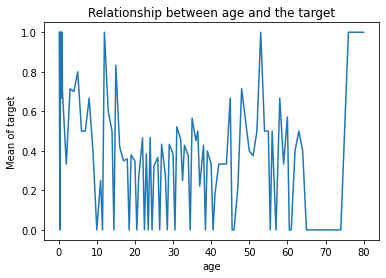

In [80]:
df_copy = df.copy()
df_copy.survived = df.survived.astype('int')

df_copy.groupby(['age'])['survived'].mean().plot()
plt.title('Relationship between age and the target')
plt.ylabel('Mean of target')
plt.show()

In [81]:
ordered_labels = df_copy.groupby(['age'])['survived'].mean().sort_values().index
ordered_labels

Float64Index([  38.5,   24.5,   23.5,   28.5,   22.5,   45.5,   20.5,   30.5,
                18.5,   66.0,   46.0,   14.5,   26.5,   67.0,   11.5,   10.0,
                34.5,   74.0,   70.5,   65.0,   55.5,   70.0,   57.0,   40.5,
                61.0,   60.5,   71.0, 0.3333,   41.0,   47.0,   37.0,   32.5,
                11.0,   21.0,   28.0,   25.0,   42.0,    2.0,   59.0,   40.0,
                44.0,   43.0,   20.0,   17.0,   18.0,   26.0,   34.0,   51.0,
                19.0,   23.0,   30.0,   50.0,    9.0,   39.0,   62.0,   64.0,
                16.0,   38.0,   33.0,   29.0,   27.0,   36.0,   32.0,   22.0,
                24.0,   63.0,   56.0,    6.0,   55.0,   54.0,   36.5,    7.0,
                52.0,   14.0,   31.0,   49.0,   35.0,   60.0,   13.0,   58.0,
                 8.0,   0.75,   45.0,    4.0,    1.0,   48.0,    3.0,    5.0,
                15.0, 0.1667,   76.0,   12.0, 0.9167, 0.8333, 0.6667, 0.4167,
                53.0,   80.0],
             dtype='float64', nam

In [82]:
ordinal_mapping = {k: i for i, k in enumerate(ordered_labels, 0)}
ordinal_mapping

{38.5: 0,
 24.5: 1,
 23.5: 2,
 28.5: 3,
 22.5: 4,
 45.5: 5,
 20.5: 6,
 30.5: 7,
 18.5: 8,
 66.0: 9,
 46.0: 10,
 14.5: 11,
 26.5: 12,
 67.0: 13,
 11.5: 14,
 10.0: 15,
 34.5: 16,
 74.0: 17,
 70.5: 18,
 65.0: 19,
 55.5: 20,
 70.0: 21,
 57.0: 22,
 40.5: 23,
 61.0: 24,
 60.5: 25,
 71.0: 26,
 0.3333: 27,
 41.0: 28,
 47.0: 29,
 37.0: 30,
 32.5: 31,
 11.0: 32,
 21.0: 33,
 28.0: 34,
 25.0: 35,
 42.0: 36,
 2.0: 37,
 59.0: 38,
 40.0: 39,
 44.0: 40,
 43.0: 41,
 20.0: 42,
 17.0: 43,
 18.0: 44,
 26.0: 45,
 34.0: 46,
 51.0: 47,
 19.0: 48,
 23.0: 49,
 30.0: 50,
 50.0: 51,
 9.0: 52,
 39.0: 53,
 62.0: 54,
 64.0: 55,
 16.0: 56,
 38.0: 57,
 33.0: 58,
 29.0: 59,
 27.0: 60,
 36.0: 61,
 32.0: 62,
 22.0: 63,
 24.0: 64,
 63.0: 65,
 56.0: 66,
 6.0: 67,
 55.0: 68,
 54.0: 69,
 36.5: 70,
 7.0: 71,
 52.0: 72,
 14.0: 73,
 31.0: 74,
 49.0: 75,
 35.0: 76,
 60.0: 77,
 13.0: 78,
 58.0: 79,
 8.0: 80,
 0.75: 81,
 45.0: 82,
 4.0: 83,
 1.0: 84,
 48.0: 85,
 3.0: 86,
 5.0: 87,
 15.0: 88,
 0.1667: 89,
 76.0: 90,
 12.0: 91,
 0.

In [83]:
df_copy['age_ordinal'] = df_copy['age'].map(ordinal_mapping)
df_copy.age_ordinal

0       59
1       92
2       37
3       50
4       35
        ..
1302    11
1303    34
1304    12
1305    60
1306    59
Name: age_ordinal, Length: 1307, dtype: int64

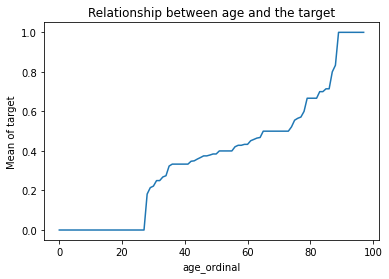

In [84]:
df_copy.groupby(['age_ordinal'])['survived'].mean().plot()
plt.title('Relationship between age and the target')
plt.ylabel('Mean of target')
plt.show()

The plot above illustrates that the encoded variable now displays a monotonic relationship with the target. The higher the mean target value, the higher the digit assigned to the category.

#### 4.5. Mean Encoding (aka Target Encoding)
Using this encoding approach, each category of the feature is replaced with the average target value for that category. For example, the **embarked** feature contains the categories **C, Q and S** where 55.5% of the passengers who embarked in Cherborg, France survived, 36.0% of the passengers who embarked at Queensland, Ireland survived, and 33.4% who embarked at Southampton, UK survived.	Accordingly, all observations where **embarked = C** will be assigned the value	**0.555**, all observations where **embarked = Q** will be assigned **0.36**, and all observations where **embarked = S** will be assigned **0.334**.

##### Using Pandas

To start, create a plot to illustrate the relationship between each category of **embarked** and the mean survival rate associated with each category.

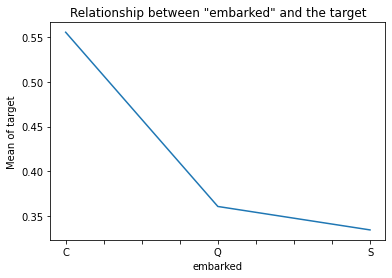

In [85]:
df_copy = df.copy()
df_copy.survived = df.survived.astype('int')

df_copy.groupby(['embarked'])['survived'].mean().plot()
plt.title('Relationship between "embarked" and the target')
plt.ylabel('Mean of target')
plt.show()

First, use the Pandas *groupby()* method over the *target* feature **survived** to create a Pandas *Series* containing the categories as indices and the *target mean* as the values. Next, use the Pandas *to_dict()* method to convert the *Series* into a dictionary, and then map the values in the dictionary to replace the categories in the Pandas *DataFrame* using the Pandas *map()* method.

In [86]:
ordered_labels = df_copy.groupby(['embarked'])['survived'].mean().to_dict()
print(ordered_labels)

df_copy['embarked_mean'] = df_copy['embarked'].map(ordered_labels)
df_copy[['embarked','embarked_mean']]

{'C': 0.5555555555555556, 'Q': 0.36065573770491804, 'S': 0.3344262295081967}


,embarked,embarked_mean
0,S,0.334426
1,S,0.334426
2,S,0.334426
3,S,0.334426
4,S,0.334426
...,...,...
1302,C,0.555556
1303,C,0.555556
1304,C,0.555556
1305,C,0.555556


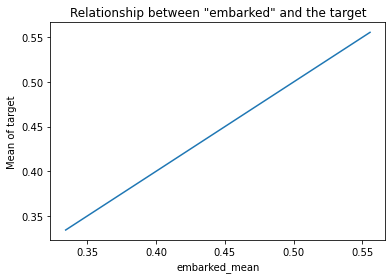

In [87]:
df_copy.groupby(['embarked_mean'])['survived'].mean().plot()
plt.title('Relationship between "embarked" and the target')
plt.ylabel('Mean of target')
plt.show()

Finally, create a plot to illustrate the relationship between each category of the newly encoded **embarked_mean** feature, and the mean survival rate associated with each category. Notice how the the **embarked_mean** feature displays a linear relationship with the mean value of the *Target* feature **survived**.

#### 4.6. Weight of Evidence (WoE) Encoding
Weight of Evidence is computed using the basic odds ratio: **WoE = log( p(Y=1) / p(Y=0) )** where **p(Y=1)** is the probability of an event occurring.

##### Using Pandas
First, create a Pandas *Series* using the probability of the target being 1 for each category in **embarked**; i.e., *p(1)*. Then, create a second *Series* using the probability of the target being 0 for each category in **embarked**; i.e., *p(0)*. Next, create a dictionary containing the **WoE** per category.

In [88]:
df_copy = df.copy()
df_copy.survived = df.survived.astype('int')

p1 = df_copy.groupby(['embarked'])['survived'].mean()
p0 = 1 - p1

woe = dict(np.log(p1/p0))

print(p1)
print(p0)
print(woe)

embarked
C    0.555556
Q    0.360656
S    0.334426
Name: survived, dtype: float64
embarked
C    0.444444
Q    0.639344
S    0.665574
Name: survived, dtype: float64
{'C': 0.22314355131420993, 'Q': -0.5725191927713306, 'S': -0.6882331657575161}


Finally, map the values in the **WoE** dictionary to replace the categories in the **embarked** feature using the Pandas *map()* method.

In [89]:
df_copy['embarked_woe'] = df_copy['embarked'].map(woe)
df_copy[['embarked','embarked_woe']]

,embarked,embarked_woe
0,S,-0.688233
1,S,-0.688233
2,S,-0.688233
3,S,-0.688233
4,S,-0.688233
...,...,...
1302,C,0.223144
1303,C,0.223144
1304,C,0.223144
1305,C,0.223144


#### 4.7. Grouping Rare *(or Infrequent)* Categories
Earlier, it was demonstrated that *rare* categories are those that are only present in a small percentage of observations. Although no *"hard and fast"* rule exists to define what constitutes *small*, typically any value below **5%** may be considered *rare*. To make matters worse it's not unusual for *rare* categories to appear in only either the *Training* dataset, or the *Testing* dataset. This situation would lead to *overfitting* during the model training process... or even rendering the model incapable of scoring observations where the *rare* category appears in the inferencing submission data. To remedy this situation, *rare* categories can be distributed to a new category named **Rare** or **Other**.

##### Using Pandas
First, inspect the distribution of categories within the feature (i.e., view the percentage of values per category).

,Percent
sibsp,
0,0.680184
1,0.244070
2,0.032135
3,0.015302
4,0.016832
5,0.004591
8,0.006886


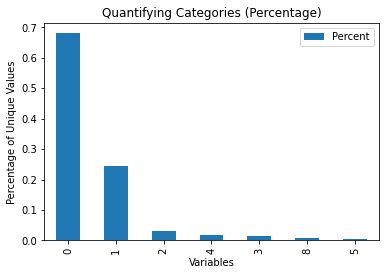

In [90]:
fig = pd.crosstab(index=df_copy['sibsp'], columns=["Percent"], colnames=[""])
percent = fig/fig.sum()
display(percent)

percent.sort_values(by=['Percent'], ascending=False).plot.bar(figsize=(6,4))
plt.ylabel('Percentage of Unique Values')
plt.xlabel('Variables')
plt.title('Quantifying Categories (Percentage)')
plt.show()

Next, define a function that enables specifying a threshold *percentage* for delineating *rare* from *frequent* occurrances, and then call that function using the feature in question and a threshold of **5%** to create separate arrays for each. Finally, inspect the newly modified distribution to verify our new category.

In [91]:
def frequent_categories(df, feature, threshold):
    percentage = df[feature].value_counts() / df.shape[0]
    frequent = [x for x in percentage.loc[percentage > threshold].index.values]
    return frequent

In [92]:
frequent_cats = frequent_categories(df_copy, 'sibsp', 0.05)
print("Frequent Categories: {0}".format(frequent_cats))

rare_cats = [x for x in df_copy['sibsp'].unique() if x not in frequent_cats]
print("Rare Categories: {0}".format(rare_cats))

Frequent Categories: [0, 1]
Rare Categories: [2, 3, 4, 5, 8]


,Percent
sibsp_grouped,
0,0.680184
1,0.244070
Other,0.075746


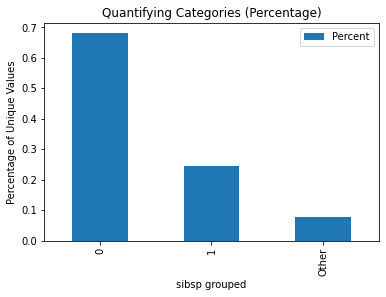

In [93]:
df_copy['sibsp_grouped'] = np.where(df_copy.sibsp.isin(frequent_cats), df_copy.sibsp, 'Other')

fig = pd.crosstab(index=df_copy['sibsp_grouped'], columns=["Percent"], colnames=[""])
percent = fig/fig.sum()
display(percent)

percent.sort_values(by=['Percent'], ascending=False).plot.bar(figsize=(6,4))
#x = sns.countplot(x="sibsp_grouped", data=df_copy)
plt.ylabel('Percentage of Unique Values')
plt.xlabel('sibsp grouped')
plt.title('Quantifying Categories (Percentage)')
plt.show()

## Section II: Creating New Features
### 5.0. Variable Discretization
Continuous features can often encompass a broad range with many increments. Many times the organic level of granularity has little impact on its influence, and may only serve to hinder the its interpretability. For example, a feature many reflect the **Age** of some person or thing where the feature contains a continuum of ages (e.g., 22, 23, 24... 65, 66, 67). In most cases the feature can be simplified by a process called *discretization* (aka, *quantization* or *binning*) so that it reflects decades (e.g., 20's, 30's, 40's, 50's) such that it is inherently more clear and understandable. In many cases the discretized feature may demonstrate more influential against the *Target* feature. Also, because the distribution of the original feature may have been skewed, discretization will help to minize the effect of outliers; thereby, improving model performance.  This is achieved when the outliers are placed into adjacent *bins* where their influence is grouped with *inliers*; thereby mitigating their negative imfluence. What's more, once a continuous feature has been simplified by converting it to one having *Nominal* attributes, it can then also be *categorically encoded* using techniques like one-hot encoding and ordinal encoding. For example, a one-hot encoded discretized feature can make a model more expressive by introducing non-linearity to a linear model.

#### 5.1. Equal Width Discretization
This technique sorts the features' values into intervals *or bins* of equal width. The number of intervals is decided arbitrarily and the width of each interval is determined by the range of the features' values and the number of bins specified. Given the variable X, the interval width is calculated using the following: **Width = Max(X) - Min(X) / Bins**.  For example, given the features' range being **0 to 100** and the number of bins specified being **5**, each bin that's produced will contain exactly **20** values: **width = (100-0) / 5 = 20)**. 

##### Using Pandas

In [94]:
df_copy = df[numerical_cols].copy()

n_bins = 10
print("Number of Bins: ", n_bins)

fare_range = df_copy['fare'].max() - df_copy['fare'].min()
print("Range: ", fare_range)
print("Bin Width: ", fare_range/n_bins)

Number of Bins:  10
Range:  512.3292
Bin Width:  51.23292


In [95]:
min_fare = int(np.floor(df_copy.fare.min()))
max_fare = int(np.ceil(df_copy.fare.max()))

interval_width = int(fare_range / n_bins)
print(f"Min Fare: {min_fare} | Max Fare: {max_fare} | Width of Intervals: {interval_width} ")

intervals = [i for i in range(min_fare, max_fare + interval_width, interval_width)]
print("Intervals: ", intervals)

Min Fare: 0 | Max Fare: 513 | Width of Intervals: 51 
Intervals:  [0, 51, 102, 153, 204, 255, 306, 357, 408, 459, 510, 561]


In [96]:
df_copy['fare_disc'] = pd.cut(x=df_copy.fare, bins=intervals, include_lowest=True)
display(df_copy[['fare', 'fare_disc']].head())

,fare,fare_disc
0,211.3375,"(204.0, 255.0]"
1,151.5500,"(102.0, 153.0]"
2,151.5500,"(102.0, 153.0]"
3,151.5500,"(102.0, 153.0]"
4,151.5500,"(102.0, 153.0]"


In [97]:
df_copy.fare_disc.value_counts()

(-0.001, 51.0]    1069
(51.0, 102.0]      154
(102.0, 153.0]      39
(204.0, 255.0]      21
(255.0, 306.0]      13
(153.0, 204.0]       7
(510.0, 561.0]       4
(306.0, 357.0]       0
(357.0, 408.0]       0
(408.0, 459.0]       0
(459.0, 510.0]       0
Name: fare_disc, dtype: int64

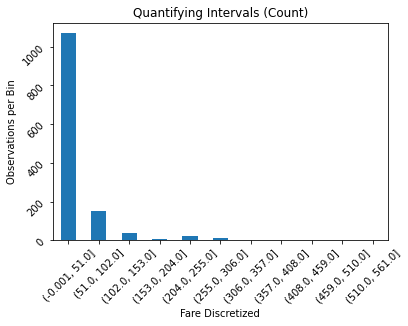

In [98]:
df_copy.groupby('fare_disc')['fare'].count().plot.bar(figsize=(6,4))
plt.yticks(rotation=45)
plt.xticks(rotation=45)
plt.ylabel('Observations per Bin')
plt.xlabel('Fare Discretized')
plt.title('Quantifying Intervals (Count)')
plt.show()

##### Using Scikit-Learn
Equal-width discretization can be achieved using Scikit-Learn's KBinsDiscretizer by specifying its *strategy* parameter as *'uniform'*. When implementing this strategy, the KBinsDiscretizer calculates the number of *bins* using the range of values in the features.

In [99]:
df_copy = df[numerical_cols].copy()

disc = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
disc.fit(df_copy)

disc.bin_edges_

array([array([ 0.1667 ,  8.15003, 16.13336, 24.11669, 32.10002, 40.08335,
       48.06668, 56.05001, 64.03334, 72.01667, 80.     ]),
       array([  0.     ,  51.23292, 102.46584, 153.69876, 204.93168, 256.1646 ,
       307.39752, 358.63044, 409.86336, 461.09628, 512.3292 ]),
       array([  1. ,  33.7,  66.4,  99.1, 131.8, 164.5, 197.2, 229.9, 262.6,
       295.3, 328. ])], dtype=object)

,age,fare,body
0,3.0,4.0,4.0
1,0.0,2.0,4.0
2,0.0,2.0,4.0
3,3.0,2.0,4.0
4,3.0,2.0,4.0


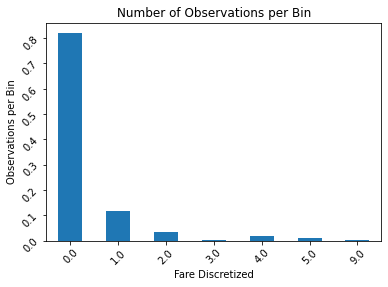

In [100]:
arr_discretized = disc.transform(df_copy)

df_discretized = pd.DataFrame(arr_discretized, columns=df_copy.columns)
display(df_discretized.head())

fare = df_discretized.groupby('fare')['fare'].count()/df_copy.shape[0]

fare.plot.bar(figsize=(6,4))
plt.yticks(rotation=45)
plt.xticks(rotation=45)
plt.ylabel('Observations per Bin')
plt.xlabel('Fare Discretized')
plt.title('Number of Observations per Bin')
plt.show()

#### 5.2. Equal Frequency Discritization
Particularly useful when a features distribution is skewed, the equal-frequency discretization technique divides the values of the feature into intervals each of which contain the same proportion of observations (i.e., it distributes the observations among the specified number of bins equally). This is achieved by determining the interval width using a user-specified number of quantiles; thereby creating intervals that may have differing widths. 

##### Using Pandas

In [101]:
df_copy = df[numerical_cols].copy()

n_bins = 10
print("Number of Bins: ", n_bins)

df_copy['age_disc'], intervals = pd.qcut(df_copy['age'], n_bins,
                                         labels=None, retbins=True, precision=3, duplicates='drop')
print("Intervals: ", intervals)
display(df_copy[['age', 'age_disc']].head())

Number of Bins:  10
Intervals:  [ 0.1667 16.     21.     24.     28.     32.     39.     48.     80.    ]


,age,age_disc
0,29.0000,"(28.0, 32.0]"
1,0.9167,"(0.166, 16.0]"
2,2.0000,"(0.166, 16.0]"
3,30.0000,"(28.0, 32.0]"
4,25.0000,"(24.0, 28.0]"


In [102]:
percentages = df_copy.age_disc.value_counts() / df_copy.shape[0]
display(percentages)

(24.0, 28.0]     0.299158
(16.0, 21.0]     0.119357
(32.0, 39.0]     0.109411
(0.166, 16.0]    0.102525
(39.0, 48.0]     0.095639
(28.0, 32.0]     0.092578
(48.0, 80.0]     0.091048
(21.0, 24.0]     0.090283
Name: age_disc, dtype: float64

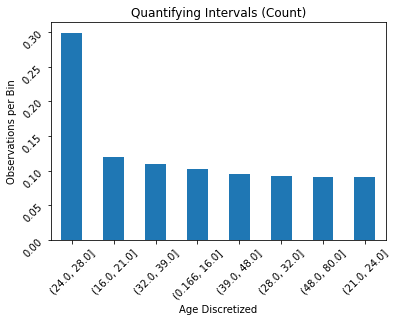

In [103]:
percentages.plot.bar(figsize=(6,4))
plt.yticks(rotation=45)
plt.xticks(rotation=45)
plt.ylabel('Observations per Bin')
plt.xlabel('Age Discretized')
plt.title('Quantifying Intervals (Count)')
plt.show()

#### 5.3. Arbitrary Value (Manual) Discretization
This technique enables you to manually determine the intervals, their boundaries, and the labels associated with each interval using arbitrary values.

In [104]:
df_copy = df[numerical_cols].copy()

bins = [0,1,13,20,30,40,50,60,110]
labels = ['Infants','Children','Teens','20s','30s','40s','50s','60+']

df_copy['age_group'] = pd.cut(df_copy.age, bins=bins, labels=labels, right=False)
df_copy.age_group = df_copy.age_group.cat.add_categories('unknown').fillna('unknown')
df_copy.age_group = df_copy.age_group.astype('object')

df_copy[['age','age_group']].head(7).sort_values(by=['age'], ascending=True)

,age,age_group
1,0.9167,Infants
2,2.0000,Children
4,25.0000,20s
0,29.0000,20s
3,30.0000,30s
5,48.0000,40s
6,63.0000,60+


##### Using Scikit-Learn

In [105]:
df_copy = df[numerical_cols].copy()

n_bins = 8
print("Number of Bins: ", n_bins)

est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal').fit(df_copy)
arr_discretized = est.transform(df_copy)

df_discretized = pd.DataFrame(arr_discretized, columns=df_copy.columns)
df_discretized.head()

Number of Bins:  8


,age,fare,body
0,5.0,7.0,0.0
1,0.0,7.0,0.0
2,0.0,7.0,0.0
3,5.0,7.0,0.0
4,2.0,7.0,0.0


#### 5.4. Discretization with K-Means Clustering
Using this technique, the intervals are determined by using the intervals identified by the k-means clustering algorithm. Similar to the previous techniques, the value *k* is specified by the user.

In [106]:
df_copy = df[numerical_cols].copy()

n_bins = 10
print("Number of Bins: ", n_bins)

disc = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='kmeans')
disc.fit(df_copy)

disc.bin_edges_

Number of Bins:  10


array([array([ 0.1667    ,  8.75014138, 17.65584648, 24.65767814, 32.20060836,
       40.32907645, 48.23184759, 56.2326454 , 64.23841463, 72.35833333,
       80.        ]),
       array([  0.        ,  18.53595137,  40.19322984,  63.16254257,
        80.01659944, 104.38089452, 138.23447688, 186.2471691 ,
       239.01187847, 386.07670625, 512.3292    ]),
       array([  1.        ,  30.12121212,  63.70512821,  99.77179487,
       140.10602578, 170.19087427, 191.53246753, 226.25274725,
       268.13846154, 300.3       , 328.        ])], dtype=object)

,age,fare,body
0,3.0,7.0,4.0
1,0.0,6.0,4.0
2,0.0,6.0,4.0
3,3.0,6.0,3.0
4,3.0,6.0,4.0


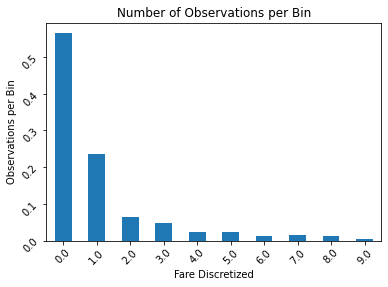

In [107]:
arr_discretized = disc.transform(df_copy)

df_discretized = pd.DataFrame(arr_discretized, columns=df_copy.columns)
display(df_discretized.head())

fare = df_discretized.groupby('fare')['fare'].count()/df_copy.shape[0]

fare.plot.bar(figsize=(6,4))
plt.yticks(rotation=45)
plt.xticks(rotation=45)
plt.ylabel('Observations per Bin')
plt.xlabel('Fare Discretized')
plt.title('Number of Observations per Bin')
plt.show()

#### 5.5. Decision Trees Discretization
Unlike the previsous Scikit-Learn techniques that use a discretizer from the *sklearn.preprocessing* library, DecisionTrees discretization uses a *DecisionTreesRegressor* modeling algorithm. When using this algorithm, the optimal number of *bins* is identified by the algorithm rather than being supplied by the user. This approach creates a monotonic relationship between the *bins* and the *target* feature that results from the decision tree rendering a prediction for each feature observation and the *target*. 

Because what is being implemented is, in fact, the training *fitting* of a machine learning model, it becomes necessary to divide the dataset into *train* and *test* dataframes. This is achieved using the *train_test_split()* method from Scikit-Learn's *model_selection* library. Here we first separate the Target *y* from the predictors *X*, and then pass them as parameters to the *train_test_split()* method.

In [108]:
df_copy = df.copy()

X = df_copy[['age','fare']]
y = df_copy.survived.astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_train.shape, X_test.shape

((914, 2), (393, 2))

Next, we *fit* the Decision Trees model and then create a new feature named *fare_tree* using the inferences produced by the model's *predict()* method. Then the number of *bins*, and their boundaries, that the model identified can be retrieved from this new feature. 

In [109]:
model = DecisionTreeRegressor(max_depth=3, random_state=0)
model.fit(X_train['fare'].to_frame(), y_train)

X_train['fare_tree'] = model.predict(X_train['fare'].to_frame())
X_test['fare_tree'] = model.predict(X_test['fare'].to_frame())

n_bins = X_train['fare_tree'].nunique()
boundaries = X_train['fare_tree'].unique()

print(f"Number of Bins: {n_bins}")
print(f"Interval Boundaries: {boundaries}")

dfs = [ X_train[['fare', 'fare_tree']].head(10), X_test[['fare', 'fare_tree']].head(10) ]
titles = ['Fare Discretized (Train)', 'Fare Discretized (Test)']

side_by_side_tables(dfs, titles)

Number of Bins: 8
Interval Boundaries: [0.17687075 0.27488152 0.47839506 0.13636364 0.37894737 0.78947368
 0.61538462 0.15789474]


,fare,fare_tree
760,9.500000,0.176871
927,7.750000,0.274882
642,31.387500,0.478395
1292,16.100000,0.478395
33,26.550000,0.478395
1297,14.454200,0.136364
1250,8.050000,0.176871
356,13.000000,0.378947
659,19.258300,0.478395
828,46.900000,0.478395


We can then plot the monotonic relationship that exist between the new *discretized* feature and the target, along with the number of observations per bin, for both the *train* and *test* dataframes.

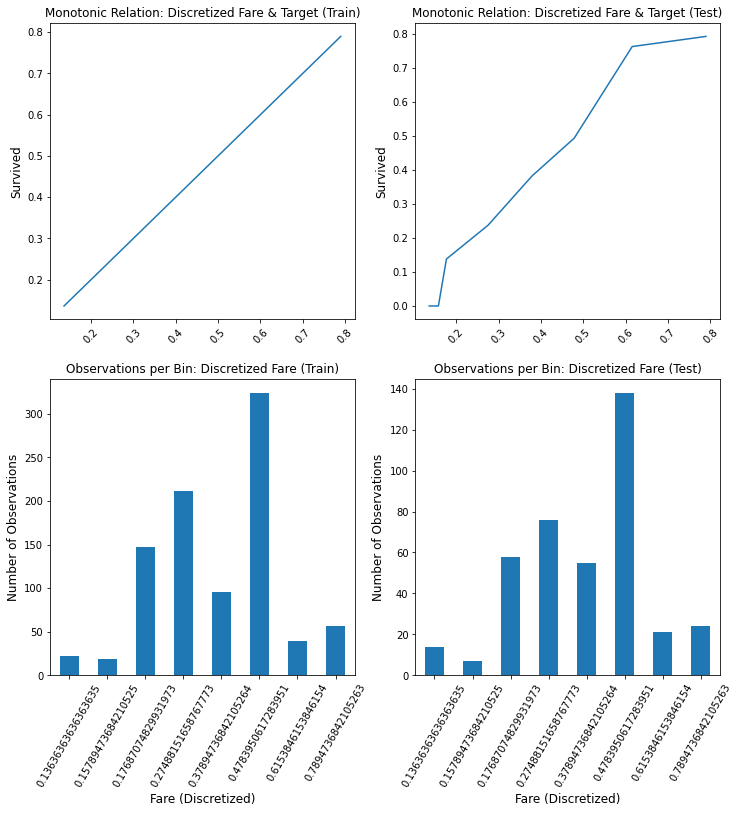

In [110]:
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

plt.figure(figsize=(12,12))

plt.subplot(2, 2, 1)
df_train.groupby(['fare_tree'])['survived'].mean().plot()
plt.title("Monotonic Relation: Discretized Fare & Target (Train)", fontsize = 12)
plt.xlabel('')
plt.xticks(rotation=45)
plt.ylabel("Survived", fontsize=12)

plt.subplot(2, 2, 2)
df_test.groupby(['fare_tree'])['survived'].mean().plot()
plt.title("Monotonic Relation: Discretized Fare & Target (Test)", fontsize = 12)
plt.xlabel('')
plt.xticks(rotation=45)
plt.ylabel("Survived", fontsize=12)

plt.subplot(2, 2, 3)
X_train.groupby(['fare_tree'])['fare'].count().plot.bar()
plt.title("Observations per Bin: Discretized Fare (Train)", fontsize = 12)
plt.xlabel("Fare (Discretized)", fontsize=12)
plt.xticks(rotation=60)
plt.ylabel("Number of Observations", fontsize=12)

plt.subplot(2, 2, 4)
X_test.groupby(['fare_tree'])['fare'].count().plot.bar()
plt.title("Observations per Bin: Discretized Fare (Test)", fontsize = 12)
plt.xlabel("Fare (Discretized)", fontsize=12)
plt.xticks(rotation=60)
plt.ylabel("Number of Observations", fontsize=12)

plt.show()

### 6.0. Deriving Features from DateTime Variables
Datetime features frequently appear in datasets as they typcially capture the date and time that various types of transactions occur (e.g., day of incident, payment date, date of sale). What's more, dates of birth and other attributes belonging to the entities that appear in a multitude of business scenarios often involve a date and/or time. In an ever-changing world, there is nearly always a datetime component. However, in their *raw* format, datetime features are all but useless to machine learning models. Fortunately, there are multiple *labels* captured within a datetime typed feature. Examples include year, month, day-of-week, day-of-month, day-of-year, is_weekday, is_weekend, is_holiday, hour, minute, and second. All of these, and more, may render real value to model development since they're far more likely to display correlation to a *target*. For example, more retail sales occur in the weeks leading to the Winter holidays. 

#### 6.1. Extracting Date and Time Parts
##### First, create a small sample of datetime values to work with. 

In [111]:
rng_ = pd.date_range('2021-03-11', periods=20, freq='T')
df_datetimes = pd.DataFrame({'date': rng_})

df_datetimes.head()

,date
0,2021-03-11 00:00:00
1,2021-03-11 00:01:00
2,2021-03-11 00:02:00
3,2021-03-11 00:03:00
4,2021-03-11 00:04:00


In [112]:
df_datetimes.dtypes

date    datetime64[ns]
dtype: object

##### Here, the date and then the time parts of the datetime typed feature observations are extracted.

In [113]:
df_datetimes['date_part'] = df_datetimes['date'].dt.date
display(df_datetimes.date_part.head())

df_datetimes['time_part'] = df_datetimes['date'].dt.time
display(df_datetimes.time_part.head())

0    2021-03-11
1    2021-03-11
2    2021-03-11
3    2021-03-11
4    2021-03-11
Name: date_part, dtype: object

0    00:00:00
1    00:01:00
2    00:02:00
3    00:03:00
4    00:04:00
Name: time_part, dtype: object

#### 6.2. Converting Object Values into DateTime Typed Features
##### First, create a small sample of *Object* typed data that represents date values. 

In [114]:
df_dtobjects = pd.DataFrame({'date_obj':['Jan-2015','Apr-2013','Jun-2014','Jan-2016']})
df_dtobjects

,date_obj
0,Jan-2015
1,Apr-2013
2,Jun-2014
3,Jan-2016


##### Next, cast (or change) the datatype to DateTime using the Pandas *to_datetime()* method.

In [115]:
df_dtobjects['datetime_var'] = pd.to_datetime(df_dtobjects['date_obj'])
df_dtobjects

,date_obj,datetime_var
0,Jan-2015,2015-01-01
1,Apr-2013,2013-04-01
2,Jun-2014,2014-06-01
3,Jan-2016,2016-01-01


##### Finally, the date and time components can be extracted, just as before.

In [116]:
df_dtobjects['date_var'] = df_dtobjects['datetime_var'].dt.date
df_dtobjects['time_var'] = df_dtobjects['datetime_var'].dt.time
df_dtobjects

,date_obj,datetime_var,date_var,time_var
0,Jan-2015,2015-01-01,2015-01-01,00:00:00
1,Apr-2013,2013-04-01,2013-04-01,00:00:00
2,Jun-2014,2014-06-01,2014-06-01,00:00:00
3,Jan-2016,2016-01-01,2016-01-01,00:00:00


#### 6.3. Extracting Year and Month
Many events occur seasonally (e.g., retail sales increase in the Autumn months). Therefore, deriving a Month feature would be useful.

##### First, create a small sample to work with.

In [117]:
rng_ = pd.date_range('2021-03-11', periods=20, freq='M')
df_dates = pd.DataFrame({'date': rng_})

df_dates.head()

,date
0,2021-03-31
1,2021-04-30
2,2021-05-31
3,2021-06-30
4,2021-07-31


##### Next, extract Year, Month, Quarter and Semester

In [118]:
df_dates['year'] = df_dates['date'].dt.year
df_dates['month'] = df_dates['date'].dt.month
df_dates['quarter'] = df_dates['date'].dt.quarter
df_dates['semester'] = np.where(df_dates['quarter'].isin([1,2]), 1, 2)

df_dates.head()

,date,year,month,quarter,semester
0,2021-03-31,2021,3,1,1
1,2021-04-30,2021,4,2,1
2,2021-05-31,2021,5,2,1
3,2021-06-30,2021,6,2,1
4,2021-07-31,2021,7,3,2


#### 6.4. Extracting Day and Week
Some events are more likely to occur on certain days of the week, or certain weeks of the year. For example, loan applications typically occur on weekdays rather than on weekends, and retail sales increase in the last weeks of December.

##### First, create a small sample to work with.

In [119]:
rng_ = pd.date_range('2021-03-11', periods=20, freq='D')
df_dates = pd.DataFrame({'date': rng_})

df_dates.head()

,date
0,2021-03-11
1,2021-03-12
2,2021-03-13
3,2021-03-14
4,2021-03-15


##### Next, Extract DayOfMonth, DayOfWeek, DayName, IsWeekday and WeekOfYear

In [120]:
df_dates['day_of_month'] = df_dates['date'].dt.day
df_dates['day_of_week'] = df_dates['date'].dt.dayofweek
df_dates['day_name'] = df_dates['date'].dt.day_name()
df_dates['is_weekend'] = np.where(df_dates['day_name'].isin(['Sunday','Saturday']), 1, 0)
df_dates['week'] = df_dates['date'].dt.week

df_dates.head()

,date,day_of_month,day_of_week,day_name,is_weekend,week
0,2021-03-11,11,3,Thursday,0,10
1,2021-03-12,12,4,Friday,0,10
2,2021-03-13,13,5,Saturday,1,10
3,2021-03-14,14,6,Sunday,1,10
4,2021-03-15,15,0,Monday,0,11


#### 6.5. Extracting Time Parts
Some events are more likely to occur at certain times of the day. For example, fraudulent activity is more likely to occur during the night and early morning hours, and emergency services are interested in the response times of first responders.

##### First, create a small sample to work with.

In [121]:
rng_ = pd.date_range('2021-03-11', periods=20, freq='1h15min10s')
df_datetimes = pd.DataFrame({'date': rng_})

df_datetimes.head()

,date
0,2021-03-11 00:00:00
1,2021-03-11 01:15:10
2,2021-03-11 02:30:20
3,2021-03-11 03:45:30
4,2021-03-11 05:00:40


#### Next, demonstrate two approaches to extracting hour, minute & second. The second approach accomplishes the task in one line.

In [122]:
df_datetimes['hr'] = df_datetimes['date'].dt.hour
df_datetimes['min'] = df_datetimes['date'].dt.minute
df_datetimes['sec'] = df_datetimes['date'].dt.second
df_datetimes.head()

,date,hr,min,sec
0,2021-03-11 00:00:00,0,0,0
1,2021-03-11 01:15:10,1,15,10
2,2021-03-11 02:30:20,2,30,20
3,2021-03-11 03:45:30,3,45,30
4,2021-03-11 05:00:40,5,0,40


In [123]:
df_datetimes[['h','m','s']] = pd.DataFrame([(x.hour, x.minute, x.second) for x in df_datetimes['date']])
df_datetimes.head()

,date,hr,min,sec,h,m,s
0,2021-03-11 00:00:00,0,0,0,0,0,0
1,2021-03-11 01:15:10,1,15,10,1,15,10
2,2021-03-11 02:30:20,2,30,20,2,30,20
3,2021-03-11 03:45:30,3,45,30,3,45,30
4,2021-03-11 05:00:40,5,0,40,5,0,40


In [124]:
df_datetimes['is_morning'] = np.where( (df_datetimes['hr'] < 12) & (df_datetimes['hr'] > 6), 1, 0 )
df_datetimes.head()

,date,hr,min,sec,h,m,s,is_morning
0,2021-03-11 00:00:00,0,0,0,0,0,0,0
1,2021-03-11 01:15:10,1,15,10,1,15,10,0
2,2021-03-11 02:30:20,2,30,20,2,30,20,0
3,2021-03-11 03:45:30,3,45,30,3,45,30,0
4,2021-03-11 05:00:40,5,0,40,5,0,40,0


#### 6.6. Calculating Elapsed Time
Important insights can be extracted by measuring the amount of time that was involved in some occurance. A simple example is that the age of people and things have significant impact on business (e.g., teenagers have the most disposable income, and items tend to wear-out as they age).

##### First, create a small sample to work with.

In [125]:
rng_hr = pd.date_range('2021-03-11', periods=20, freq='H')
rng_month = pd.date_range('2021-03-11', periods=20, freq='M')

df_hrs_mnths = pd.DataFrame({'date1': rng_hr, 'date2': rng_month}) 
df_hrs_mnths.head()

,date1,date2
0,2021-03-11 00:00:00,2021-03-31
1,2021-03-11 01:00:00,2021-04-30
2,2021-03-11 02:00:00,2021-05-31
3,2021-03-11 03:00:00,2021-06-30
4,2021-03-11 04:00:00,2021-07-31


In [126]:
df_hrs_mnths['elapsed_days'] = (df_hrs_mnths['date2'] - df_hrs_mnths['date1']).dt.days
df_hrs_mnths.head()

,date1,date2,elapsed_days
0,2021-03-11 00:00:00,2021-03-31,20
1,2021-03-11 01:00:00,2021-04-30,49
2,2021-03-11 02:00:00,2021-05-31,80
3,2021-03-11 03:00:00,2021-06-30,110
4,2021-03-11 04:00:00,2021-07-31,141


In [127]:
df_hrs_mnths['months_passed'] = ((df_hrs_mnths['date2'] - df_hrs_mnths['date1']) / np.timedelta64(1, 'M'))
df_hrs_mnths['months_passed'] = np.round(df_hrs_mnths['months_passed'], 0)
df_hrs_mnths.head()

,date1,date2,elapsed_days,months_passed
0,2021-03-11 00:00:00,2021-03-31,20,1.0
1,2021-03-11 01:00:00,2021-04-30,49,2.0
2,2021-03-11 02:00:00,2021-05-31,80,3.0
3,2021-03-11 03:00:00,2021-06-30,110,4.0
4,2021-03-11 04:00:00,2021-07-31,141,5.0


In [128]:
df_hrs_mnths['diff_seconds'] = (df_hrs_mnths['date2'] - df_hrs_mnths['date1'])/np.timedelta64(1,'s')
df_hrs_mnths['diff_minutes'] = (df_hrs_mnths['date2'] - df_hrs_mnths['date1'])/np.timedelta64(1,'m')
df_hrs_mnths.head()

,date1,date2,elapsed_days,months_passed,diff_seconds,diff_minutes
0,2021-03-11 00:00:00,2021-03-31,20,1.0,1728000.0,28800.0
1,2021-03-11 01:00:00,2021-04-30,49,2.0,4316400.0,71940.0
2,2021-03-11 02:00:00,2021-05-31,80,3.0,6991200.0,116520.0
3,2021-03-11 03:00:00,2021-06-30,110,4.0,9579600.0,159660.0
4,2021-03-11 04:00:00,2021-07-31,141,5.0,12254400.0,204240.0


In [129]:
df_hrs_mnths['to_today'] = (datetime.datetime.today() - df_hrs_mnths['date1'])
df_hrs_mnths.head()

,date1,date2,elapsed_days,months_passed,diff_seconds,diff_minutes,to_today
0,2021-03-11 00:00:00,2021-03-31,20,1.0,1728000.0,28800.0,337 days 19:40:22.459027
1,2021-03-11 01:00:00,2021-04-30,49,2.0,4316400.0,71940.0,337 days 18:40:22.459027
2,2021-03-11 02:00:00,2021-05-31,80,3.0,6991200.0,116520.0,337 days 17:40:22.459027
3,2021-03-11 03:00:00,2021-06-30,110,4.0,9579600.0,159660.0,337 days 16:40:22.459027
4,2021-03-11 04:00:00,2021-07-31,141,5.0,12254400.0,204240.0,337 days 15:40:22.459027


#### 6.7. Working Across TimeZones
Since many organizations operate internationally, they will be collecting data regarding events that occur in different time zones.

##### First, create a small sample to work with.

In [130]:
df_tz = pd.DataFrame()

df_tz['time1'] = pd.concat([
    pd.Series(pd.date_range(start='2021-06-10 09:00', freq='H', periods=3, tz='Europe/Berlin')),
    pd.Series(pd.date_range(start='2021-09-10 09:00', freq='H', periods=3, tz='US/Central'))
    ], axis=0)

df_tz['time2'] = pd.concat([
    pd.Series(pd.date_range(start='2021-07-01 09:00', freq='H', periods=3, tz='Europe/Berlin')),
    pd.Series(pd.date_range(start='2021-08-01 09:00', freq='H', periods=3, tz='US/Central'))
    ], axis=0)

df_tz

,time1,time2
0,2021-06-10 09:00:00+02:00,2021-07-01 09:00:00+02:00
1,2021-06-10 10:00:00+02:00,2021-07-01 10:00:00+02:00
2,2021-06-10 11:00:00+02:00,2021-07-01 11:00:00+02:00
0,2021-09-10 09:00:00-05:00,2021-08-01 09:00:00-05:00
1,2021-09-10 10:00:00-05:00,2021-08-01 10:00:00-05:00
2,2021-09-10 11:00:00-05:00,2021-08-01 11:00:00-05:00


##### Next, unify to the central time zone (i.e., Zulu or GMT), and then display the variable's data type.

In [131]:
df_tz['time1_utc'] = pd.to_datetime(df_tz['time1'], utc=True)
df_tz['time2_utc'] = pd.to_datetime(df_tz['time2'], utc=True)
df_tz

,time1,time2,time1_utc,time2_utc
0,2021-06-10 09:00:00+02:00,2021-07-01 09:00:00+02:00,2021-06-10 07:00:00+00:00,2021-07-01 07:00:00+00:00
1,2021-06-10 10:00:00+02:00,2021-07-01 10:00:00+02:00,2021-06-10 08:00:00+00:00,2021-07-01 08:00:00+00:00
2,2021-06-10 11:00:00+02:00,2021-07-01 11:00:00+02:00,2021-06-10 09:00:00+00:00,2021-07-01 09:00:00+00:00
0,2021-09-10 09:00:00-05:00,2021-08-01 09:00:00-05:00,2021-09-10 14:00:00+00:00,2021-08-01 14:00:00+00:00
1,2021-09-10 10:00:00-05:00,2021-08-01 10:00:00-05:00,2021-09-10 15:00:00+00:00,2021-08-01 15:00:00+00:00
2,2021-09-10 11:00:00-05:00,2021-08-01 11:00:00-05:00,2021-09-10 16:00:00+00:00,2021-08-01 16:00:00+00:00


In [132]:
df_tz['elapsed_days'] = (df_tz['time2_utc'] - df_tz['time1_utc']).dt.days
df_tz['elapsed_days'].head()

0    21
1    21
2    21
0   -40
1   -40
Name: elapsed_days, dtype: int64

##### Finally, change all timestamps to the desired timezone (e.g., Europe/London)

In [133]:
df_tz['time1_london'] = df_tz['time1_utc'].dt.tz_convert('Europe/London')
df_tz['time2_berlin'] = df_tz['time1_utc'].dt.tz_convert('Europe/Berlin')
df_tz[['time1_london', 'time2_berlin']]

,time1_london,time2_berlin
0,2021-06-10 08:00:00+01:00,2021-06-10 09:00:00+02:00
1,2021-06-10 09:00:00+01:00,2021-06-10 10:00:00+02:00
2,2021-06-10 10:00:00+01:00,2021-06-10 11:00:00+02:00
0,2021-09-10 15:00:00+01:00,2021-09-10 16:00:00+02:00
1,2021-09-10 16:00:00+01:00,2021-09-10 17:00:00+02:00
2,2021-09-10 17:00:00+01:00,2021-09-10 18:00:00+02:00


### 7.0. Deriving Features by Mathematical Computation
By implementing mathematical and/or statistical operations using existing (numerical) features as input, new features can be created that can potentially outperform the *organic* features from which they were derived. For example, when predicting whether to grant a loan, the applicant would naturally be asked to supply their current income level and outstanding debts. Their *debt to income ratio* can then be calculated by first *summing* all their monthly debts and then dividing that by their monthly income.  We can, in fact, use any combination of mathematical or statistical operations to create new features including minimum, maximum, mean, standard deviation, variance, sum, difference, product, etc. 

#### 7.1. Combining Multiple Features with Mathematical and Statistical Operations
##### First, Get a sample dataset to work with

In [134]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
df_wdbc = pd.DataFrame(data.data, columns=data.feature_names)

X = ['mean smoothness','mean compactness','mean concavity','mean concave points','mean symmetry']
df_wdbc = df_wdbc[X]

df_wdbc['wdbc-malignant'] = data.target
 
df_wdbc.head()

,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,wdbc-malignant
0,0.11840,0.27760,0.3001,0.14710,0.2419,0
1,0.08474,0.07864,0.0869,0.07017,0.1812,0
2,0.10960,0.15990,0.1974,0.12790,0.2069,0
3,0.14250,0.28390,0.2414,0.10520,0.2597,0
4,0.10030,0.13280,0.1980,0.10430,0.1809,0


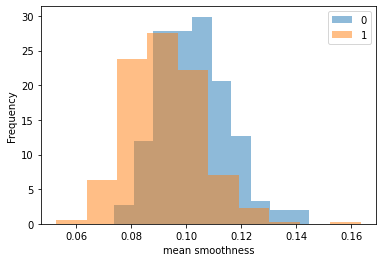

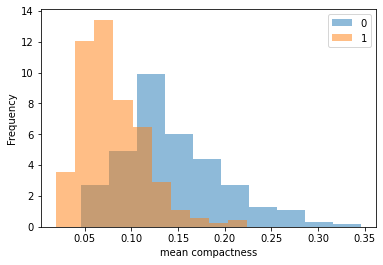

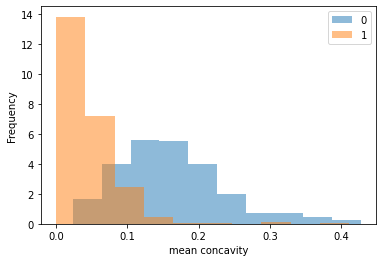

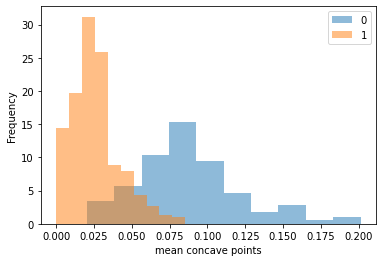

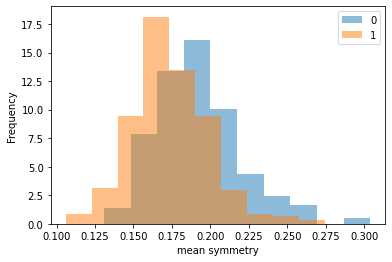

In [135]:
for col in df_wdbc.columns:
    if col != 'wdbc-malignant':
        plt.figure()
        df_wdbc.groupby(df_wdbc['wdbc-malignant'])[col].plot.hist(alpha=0.5, density=True, legend=True)
        plt.xlabel(col)

##### 7.1.1. Addition: Sum All the Features to Derive a New Feature

In [136]:
df_wdbc['sum_features'] = df_wdbc[X].sum(axis=1)
df_wdbc.sum_features.head()

0    1.08510
1    0.50165
2    0.80170
3    1.03270
4    0.71630
Name: sum_features, dtype: float64

##### 7.1.2. Product: Multiply All the Features to Derive a New Feature

In [137]:
df_wdbc['prod_features'] = df_wdbc[X].prod(axis=1)
df_wdbc.prod_features.head()

0    0.000351
1    0.000007
2    0.000092
3    0.000267
4    0.000050
Name: prod_features, dtype: float64

##### 7.1.3. Average: Calculate the Mean of All the Features to Derive a New Feature

In [138]:
df_wdbc['mean_features'] = df_wdbc[X].mean(axis=1)
df_wdbc.mean_features.head()

0    0.21702
1    0.10033
2    0.16034
3    0.20654
4    0.14326
Name: mean_features, dtype: float64

##### 7.1.4. Standard Deviation: Calculate the Standard Deviation of All the Features to Derive a New Feature

In [139]:
df_wdbc['std_features'] = df_wdbc[X].std(axis=1)
df_wdbc.std_features.head()

0    0.080321
1    0.045671
2    0.042333
3    0.078097
4    0.044402
Name: std_features, dtype: float64

##### 7.1.5. Maximum: Use the Maximum Value of All the Features to Derive a New Feature

In [140]:
df_wdbc['max_features'] = df_wdbc[X].max(axis=1)
df_wdbc.max_features.head()

0    0.3001
1    0.1812
2    0.2069
3    0.2839
4    0.1980
Name: max_features, dtype: float64

##### 7.1.6. Minimum: Use the Minimum of All the Features to Derive a New Feature

In [141]:
df_wdbc['min_features'] = df_wdbc[X].min(axis=1)
df_wdbc.min_features.head()

0    0.11840
1    0.07017
2    0.10960
3    0.10520
4    0.10030
Name: min_features, dtype: float64

##### 7.1.7. Derive All of These New Features by Performing All the Operations in One Line
The **agg()** method of a Pandas DataFrame takes a *list* of strings corresponding to the mathematical operations to apply. It then returns a Pandas DataFrame having a new column for each mathematical operation that was specified.

Then, by plotting the distribution of values within these new features, we can illustrate that they display a greater separation between the two categories of the *Target* variable i.e., between *Malignant* and *Benign* tumors.

In [142]:
df_ops = df_wdbc[X].agg(['sum','prod','mean','std','max','min'], axis='columns')
df_ops.head()

,sum,prod,mean,std,max,min
0,1.08510,0.000351,0.21702,0.080321,0.3001,0.11840
1,0.50165,0.000007,0.10033,0.045671,0.1812,0.07017
2,0.80170,0.000092,0.16034,0.042333,0.2069,0.10960
3,1.03270,0.000267,0.20654,0.078097,0.2839,0.10520
4,0.71630,0.000050,0.14326,0.044402,0.1980,0.10030


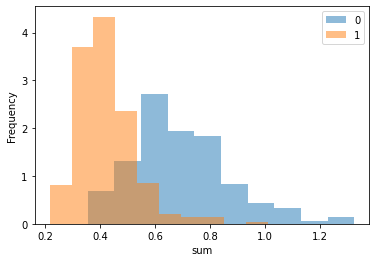

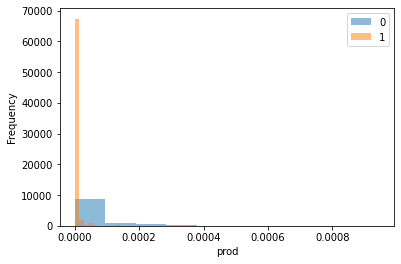

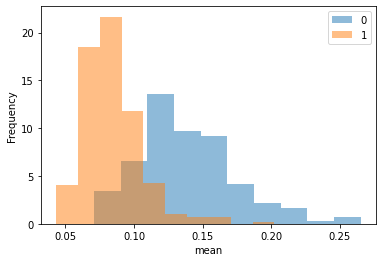

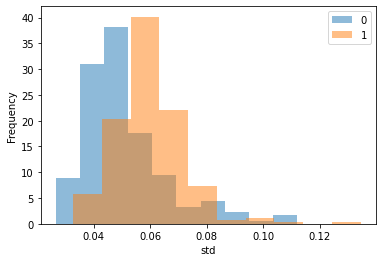

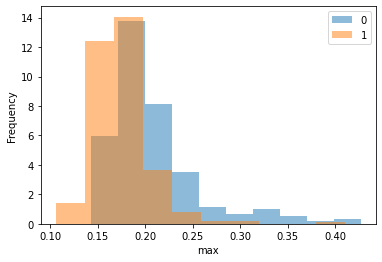

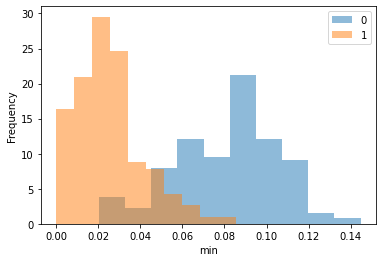

In [143]:
df_ops['wdbc-malignant'] = df_wdbc['wdbc-malignant']

for col in df_ops.columns:
    if col != 'wdbc-malignant':
        plt.figure()
        df_ops.groupby(df_ops['wdbc-malignant'])[col].plot.hist(alpha=0.5, density=True, legend=True)
        plt.xlabel(col)

#### 7.2. Combining Feature Pairs Using Mathematical Functions
Certain mathematical operations (e.g., subtraction, division) make better sense when performed between only two features, or when considering multiple features against one reference variable. An example of such an operation would be the deriving of ratios (e.g., debt-to-income ratio).

In [144]:
data = load_breast_cancer()
df_wdbc = pd.DataFrame(data.data, columns=data.feature_names)
df_wdbc['wdbc-malignant'] = data.target
 
df_wdbc.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,wdbc-malignant
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


##### 7.2.1. Calculate the Difference Between 2 Features (Method 1)

In [145]:
df_wdbc['diff'] = df_wdbc['worst compactness'].sub(df_wdbc['mean compactness'])
df_wdbc['diff'].head()

0    0.38800
1    0.10796
2    0.26460
3    0.58240
4    0.07220
Name: diff, dtype: float64

##### 7.2.2. Calculate the Difference Between 2 Features (Method 2)

In [146]:
df_wdbc['diff'] = df_wdbc['worst compactness'] - df_wdbc['mean compactness']
df_wdbc['diff'].head()

0    0.38800
1    0.10796
2    0.26460
3    0.58240
4    0.07220
Name: diff, dtype: float64

##### 7.2.3. Calculate the Quotient of 2 Features (Method 1)

In [147]:
df_wdbc['quotient'] = df_wdbc['worst radius'].div(df_wdbc['mean radius'])
df_wdbc['quotient'].head()

0    1.410784
1    1.214876
2    1.197054
3    1.305604
4    1.110892
Name: quotient, dtype: float64

##### 7.2.4. Calculate the Quotient of 2 Features (Method 2)

In [148]:
df_wdbc['quotient'] = df_wdbc['worst radius'] / df_wdbc['mean radius']
df_wdbc['quotient'].head()

0    1.410784
1    1.214876
2    1.197054
3    1.305604
4    1.110892
Name: quotient, dtype: float64

##### 7.2.5. Sum All the 'Worst' Features to Derive a New Feature

In [149]:
X_mean = ['mean smoothness','mean compactness','mean concavity','mean concave points','mean symmetry']
X_worst = ['worst smoothness','worst compactness','worst concavity','worst concave points','worst symmetry']

df_wdbc['worst'] = df_wdbc[X_worst].sum(axis=1)
df_wdbc['worst'].head()

0    2.2652
1    1.0130
2    1.6236
3    2.6843
4    1.1413
Name: worst, dtype: float64

In [150]:
df_wdbc[X_mean + ['worst']].head()

,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,worst
0,0.11840,0.27760,0.3001,0.14710,0.2419,2.2652
1,0.08474,0.07864,0.0869,0.07017,0.1812,1.0130
2,0.10960,0.15990,0.1974,0.12790,0.2069,1.6236
3,0.14250,0.28390,0.2414,0.10520,0.2597,2.6843
4,0.10030,0.13280,0.1980,0.10430,0.1809,1.1413


##### 7.2.6. Calculate the Ratio of All the 'Mean' Features vs. the New 'Worst' Feature to Derive a New Feature

In [151]:
df_wdbc[X_mean] = df_wdbc[X_mean].div(df_wdbc['worst'], axis=0)
df_wdbc[X_mean].head()

,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry
0,0.052269,0.122550,0.132483,0.064939,0.106790
1,0.083653,0.077631,0.085785,0.069269,0.178875
2,0.067504,0.098485,0.121582,0.078776,0.127433
3,0.053086,0.105763,0.089930,0.039191,0.096748
4,0.087882,0.116359,0.173486,0.091387,0.158503


#### 7.3. Polynomial Expansion
New features can be created by combining an individual feature with itself; i.e., a polynomial combination of the same feature. This approach can be beneficial in cases where the *target* feature follows a quadratic relationship with a particular *predictor*.

##### First, get a sample dataset to work with.

In [152]:
df_copy = df[numerical_cols].copy()
df_copy.head()

,age,fare,body
0,29.0000,211.3375,160.667892
1,0.9167,151.5500,160.715252
2,2.0000,151.5500,160.715252
3,30.0000,151.5500,135.000000
4,25.0000,151.5500,160.715252


##### Then, separate the target from the predictors and perform a train/test split.

In [153]:
X = df_copy
y = df.survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_train.shape, X_test.shape

((914, 3), (393, 3))

##### Visualize the distribution of values of the input features as they compare to the target

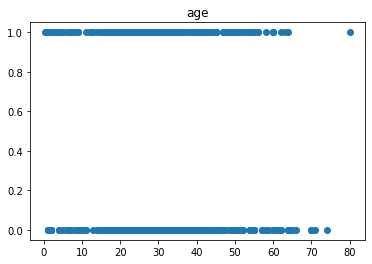

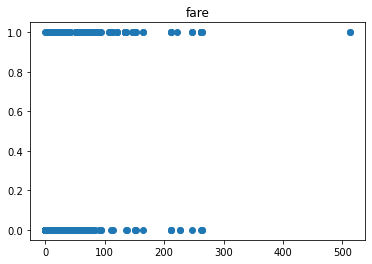

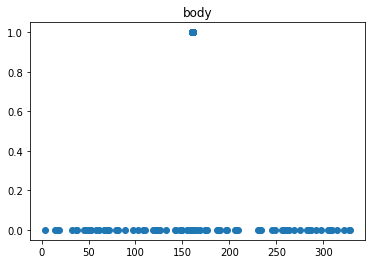

In [154]:
for f in ['age','fare','body']:
    plt.scatter(X_train[f], y_train)
    plt.title(f)
    plt.show()

##### Configure and Train the Polynomial Expansion Transformer

In [155]:
poly = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
poly.fit(X_train)

PolynomialFeatures(degree=3, include_bias=False)

##### Use the Transformer to Create the New Features

In [156]:
X_train_transformed = poly.transform(X_train)
X_test_transformed = poly.transform(X_test)

##### View the Newly Created Features

In [157]:
poly.get_feature_names(X_train.columns.to_list())

['age',
 'fare',
 'body',
 'age^2',
 'age fare',
 'age body',
 'fare^2',
 'fare body',
 'body^2',
 'age^3',
 'age^2 fare',
 'age^2 body',
 'age fare^2',
 'age fare body',
 'age body^2',
 'fare^3',
 'fare^2 body',
 'fare body^2',
 'body^3']

##### Capture the Newly Created Features in a DataFrame

In [158]:
X_test_transformed = pd.DataFrame(X_test_transformed)
X_test_transformed.columns = poly.get_feature_names(X_train.columns.to_list())
X_test_transformed.head()

,age,fare,body,age^2,age fare,age body,fare^2,fare body,body^2,age^3,age^2 fare,age^2 body,age fare^2,age fare body,age body^2,fare^3,fare^2 body,fare body^2,body^3
0,21.0,6.4958,160.830155,441.0,136.4118,3377.433252,42.195418,1044.720520,25866.338713,9261.0,2864.6478,70926.098295,886.103770,21939.130919,5.431931e+05,274.092994,6.786296e+03,1.680226e+05,4.160087e+06
1,40.0,39.0000,160.804407,1600.0,1560.0000,6432.176282,1521.000000,6271.371875,25858.057327,64000.0,62400.0000,257287.051283,60840.000000,250854.875001,1.034322e+06,59319.000000,2.445835e+05,1.008464e+06,4.158090e+06
2,4.0,16.7000,160.822072,16.0,66.8000,643.288287,278.890000,2685.728598,25863.738755,64.0,267.2000,2573.153148,1115.560000,10742.914391,1.034550e+05,4657.463000,4.485167e+04,4.319244e+05,4.159460e+06
3,64.0,83.1583,160.769428,4096.0,5322.1312,10289.243366,6915.302859,13369.312290,25846.808846,262144.0,340616.3968,658511.575393,442579.382969,855635.986563,1.654196e+06,575064.829730,1.111769e+06,2.149377e+06,4.155377e+06
4,28.0,7.8792,153.000000,784.0,220.6176,4284.000000,62.081793,1205.517600,23409.000000,21952.0,6177.2928,119952.000000,1738.290194,33754.492800,6.554520e+05,489.154861,9.498514e+03,1.844442e+05,3.581577e+06


##### Create a Plot to Compare the New Features versus the Target

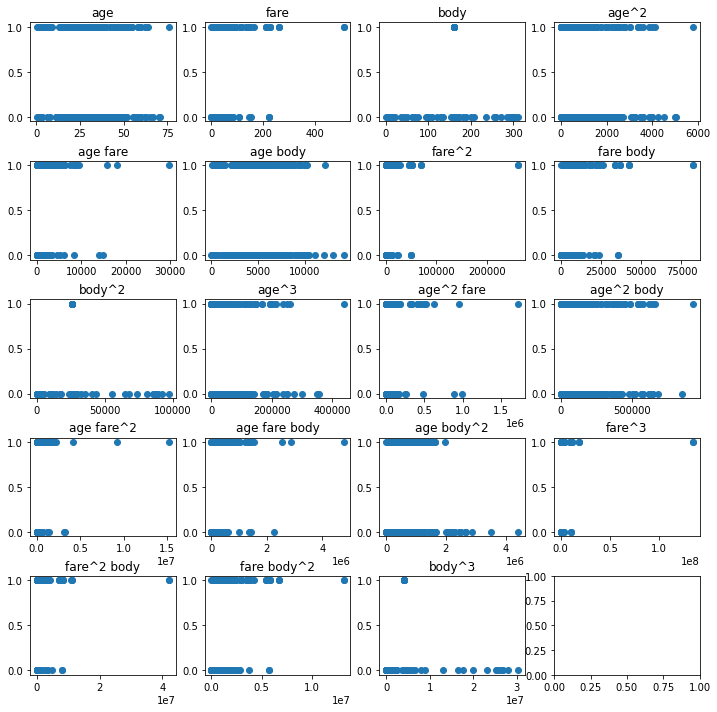

In [159]:
def plot_features(X_test_t, y_test):
    nb_rows = 5
    nb_cols = 4
    
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(12, 12))
    plt.subplots_adjust(wspace=None, hspace=0.4)

    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            if n!=19:
                axs[i, j].scatter(X_test_t[X_test_t.columns[n]], y_test)
                axs[i, j].set_title(X_test_t.columns[n])
                n += 1
    plt.show()
    
plot_features(X_test_transformed, y_test)

#### 7.4. Feature Combination with Trees
Decison Trees can be used to derive new features using two or more *organic* features. By training a decision tree using a subset of the features from an input dataset, the predictions from the tree can then be used as a new feature. The newly created features will be monotonic with the *target* feature, which is particularly useful when training linear models.

##### First, get a sample dataset to work with.

In [160]:
df_copy = df[numerical_cols].copy()
df_copy.head()

,age,fare,body
0,29.0000,211.3375,160.667892
1,0.9167,151.5500,160.715252
2,2.0000,151.5500,160.715252
3,30.0000,151.5500,135.000000
4,25.0000,151.5500,160.715252


##### Then, separate the target from the predictors and perform a train/test split.

In [161]:
X = df_copy
y = df.survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_train.shape, X_test.shape

((914, 3), (393, 3))

##### Visualize the distribution of values of the input features as they compare to the target

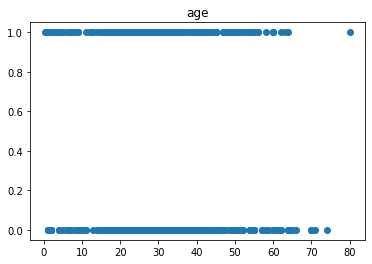

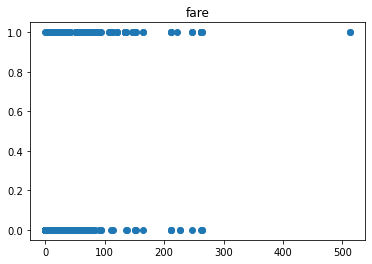

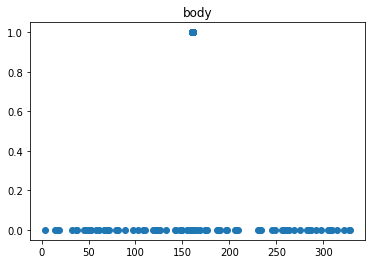

In [162]:
for f in ['age','fare','body']:
    plt.scatter(X_train[f], y_train)
    plt.title(f)
    plt.show()

##### Next, train a decision tree model using the input features (tune the 'max_depth' hyperparameter)

In [163]:
param_grid = {'max_depth': [3, 4, None]}

model = GridSearchCV(DecisionTreeRegressor(random_state=42),
                     cv=5, scoring='neg_mean_squared_error', param_grid=param_grid)
model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [3, 4, None]},
             scoring='neg_mean_squared_error')

##### Finally, assign the predictions to a new feature, and visualize its distribution of values compared to the target

Text(0.5, 1.0, 'Tree-Derived Feature vs. Survival')

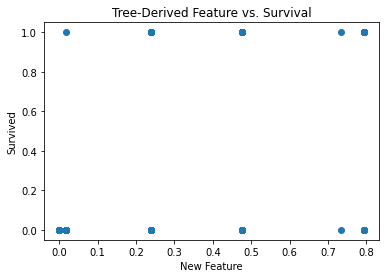

In [164]:
X_train['new_feature'] = model.predict(X_train)
X_test['new_feature'] = model.predict(X_test)

plt.scatter(X_test.new_feature, y_test)
plt.ylabel('Survived')
plt.xlabel('New Feature')
plt.title('Tree-Derived Feature vs. Survival')

#### 7.5. Principal Component Analysis (PCA)
Principal Component Analysis (PCA) is an unsupervised learning algorithm that's frequently used to address problems including hyperparametric data and the presence of non-linear feature correlations. Implementing a technique called matrix decomposition, PCA creates uncorrelated linear combinations using the original features, and then projects the sum of their discriminatory power onto a much smaller dimensional space. In other words, the predictive power of a large number of features is "distilled" into a smaller number of more powerful "components". The resulting components are fully independent and uncorrelated (i.e., they exhibit no relation to one another) and are ranked according to their "explained variance" (i.e., the amount of variance they represent from the original features). One drawback of implementing PCA is that it isn't easily interpretable since it obscures the identity of the features as they contribute to the predictive power of the dataset. Therefore, its use is appropriate when it is unnecessary to understand the origin of the prediction.

##### First, get the data set

In [165]:
cols = ['age', 'fare', 'body', 'cabin', 'embarked', 'boat', 'sex', 'sibsp', 'parch', 'ticket']

df_copy = df[cols].copy()
df_copy.head()

,age,fare,body,cabin,embarked,boat,sex,sibsp,parch,ticket
0,29.0000,211.3375,160.667892,B5,S,2,female,0,0,24160
1,0.9167,151.5500,160.715252,C22,S,11,male,1,2,113781
2,2.0000,151.5500,160.715252,C22,S,unknown,female,1,2,113781
3,30.0000,151.5500,135.000000,C22,S,unknown,male,1,2,113781
4,25.0000,151.5500,160.715252,C22,S,unknown,female,1,2,113781


In [166]:
X = df_copy
y = df.survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_train.shape, X_test.shape

((914, 10), (393, 10))

In [167]:
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[("ore", OrdinalEncoder())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, selector(dtype_exclude="object")),
        ("cat", categorical_transformer, selector(dtype_include="object")),
    ]
)

pca = PCA(n_components=None)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("pca", pca)
    ]
)

pipeline.fit(X_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb48b8dd640>),
                                                 ('cat',
                                                  Pipeline(steps=[('ore',
                                                                   OrdinalEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb48b8dd190>)])),
                ('pca', PCA())])

The following plot illustrates that PCA has distilled nearly all of the discriminatory power of the dataset into the first component. 

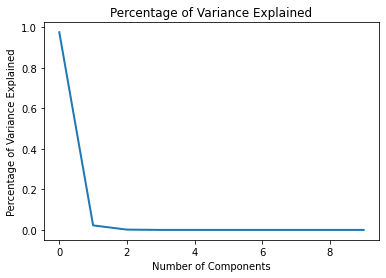

In [168]:
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.title('Percentage of Variance Explained')
plt.xlabel('Number of Components')
plt.ylabel('Percentage of Variance Explained')
plt.show()

### 8.0. Extracting Features from Text Variables
It's not uncommon to encounter features containing unstructured text. Examples include product descriptions, customer reviews or feedback, notes taken by customer service reps or insurance claims adjusters, etc. Unlike the values typically found in structured (tabular) data, unstructured text does not follow a predetermined pattern; i.e., it can vary in its length, content, vernacular and writing style. The unstructured nature of these features present an unique challenge with regards to extracting useful information; i.e., new text features that would consistently influence the efficacy of a machine learning model.

Feature engineering in this domain is accommplished via **Natural Language Processing (NLP)**; an aspect of data science that's concerned with interpreting or understanding human language. This section will only briefly address this topic for the sake of introducing techniques and software required to extract useful features from unstructured text.

#### 8.1. Capture the Complexity of the Text

##### First, fetch a dataset containing unstructured text data

In [169]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups(subset='train')
df_text = pd.DataFrame(data.data, columns=['text'])
df_text.head()

,text
0,From: lerxst@wam.umd.edu (where's my thing)\nS...
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...


#### Next, count the number of characters, and the number of words, using the strip() function to remove trailing white spaces.

In [170]:
df_text['num_chars'] = df_text['text'].str.strip().str.len()
df_text['num_words'] = df_text['text'].str.strip().str.split().str.len()
df_text.head()

,text,num_chars,num_words
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,716,123
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,857,123
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,1980,339
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,814,113
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,1117,171


#### Then, Determine Vocabulary

In [171]:
df_text['num_vocab'] = df_text['text'].str.split().apply(set).str.len()
df_text.head()

,text,num_chars,num_words,num_vocab
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,716,123,96
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,857,123,103
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,1980,339,220
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,814,113,97
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,1117,171,140


In [172]:
# Set charaters to lower case before counting unique words

df_text['num_vocab'] = df_text['text'].str.lower().str.split().apply(set).str.len()
df_text.head()

,text,num_chars,num_words,num_vocab
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,716,123,93
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,857,123,99
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,1980,339,219
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,814,113,96
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,1117,171,139


##### Next, Determine Lexical Diversity

In [173]:
df_text['lexical_div'] = df_text['num_words'] / df_text['num_vocab']
df_text.head()

,text,num_chars,num_words,num_vocab,lexical_div
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,716,123,93,1.322581
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,857,123,99,1.242424
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,1980,339,219,1.547945
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,814,113,96,1.177083
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,1117,171,139,1.230216


##### Then, Calculate the Average Word Length

In [174]:
df_text['ave_word_length'] = df_text['num_chars'] / df_text['num_words']
df_text.head()

,text,num_chars,num_words,num_vocab,lexical_div,ave_word_length
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,716,123,93,1.322581,5.821138
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,857,123,99,1.242424,6.967480
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,1980,339,219,1.547945,5.840708
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,814,113,96,1.177083,7.203540
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,1117,171,139,1.230216,6.532164


##### Finally, Plot the Distribution of Created Features Across the Different Topics Referred To in the Text.

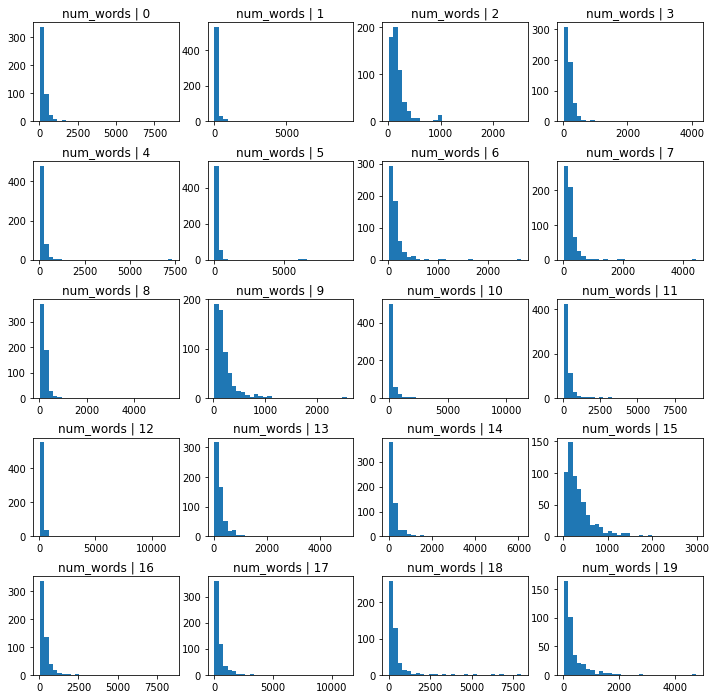

In [175]:
df_text['target'] = data.target

def plot_features(df, text_var):
    nb_rows = 5
    nb_cols = 4
    
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(12, 12))
    plt.subplots_adjust(wspace=None, hspace=0.4)

    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].hist(df[df.target==n][text_var], bins=30)
            axs[i, j].set_title(text_var + ' | ' + str(n))
            n += 1
    plt.show()
    
    
plot_features(df_text, 'num_words')

#### 8.2. Sentence Tokenization
It's useful to understand the complexity of text features. Longer descriptions containing multiple sentences and paragraphs will typically render more useful information than those that are shorter; thus, counting sentences will naturally provide some insight into the volume of useful data we may expect to glean from text features. In a process called *sentence tokenization*, strings are split into small pieces, or *tokens*.

In [176]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/azureuser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [177]:
data = fetch_20newsgroups(subset='train')
df_text = pd.DataFrame(data.data, columns=['text'])
df_text.head()

,text
0,From: lerxst@wam.umd.edu (where's my thing)\nS...
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...


In [178]:
# Take only the first 10 Rows.
df_text = df_text.loc[1:10]

# Remove the emails' sender, subject, and other stuff we don't need.
df_text['text'] = df_text['text'].str.split('Lines:').apply(lambda x: x[1])

In [179]:
# Finally, capture the number of sentences per observation.
df_text['num_sent'] = df_text['text'].apply(sent_tokenize).apply(len)
df_text

,text,num_sent
1,11\nNNTP-Posting-Host: carson.u.washington.ed...,6
2,"36\n\nwell folks, my mac plus finally gave up...",9
3,14\nDistribution: world\nNNTP-Posting-Host: a...,7
4,23\n\nFrom article <C5owCB.n3p@world.std.com>...,10
5,58\n\nIn article <1r1eu1$4t@transfer.stratus....,21
6,12\n\nThere were a few people who responded t...,8
7,44\nDistribution: world\nNNTP-Posting-Host: d...,15
8,10\n\nI have win 3.0 and downloaded several i...,3
9,29\n\njap10@po.CWRU.Edu (Joseph A. Pellettier...,12
10,13\n\nI have a line on a Ducati 900GTS 1978 m...,11


#### 8.2 Bag-of-Words and N-Grams
Fundamental concepts to the field of natural language processing (NLP) are the *bag of words (BoW)* and the *n-gram*. The **bag of words** represents a given text fragment in terms of the number of words that it contains along with the number of times each word appears. For example, using the text "Dogs like cats, but cats do not like dogs", a variable is created for each word in the fragment where the words "dogs", "like" and "cats" all appear twice each, but the words "but", "do", and "not" each appear only once. A *bag of words* represents multiplicity, but not word order or grammer.

The **n-gram** represents the contiguous sequence of *n* items in a text fragment. For example, using the text "*The quick red fox jumped over the lazy brown dog*", the *2-grams* derived would be: "The quick", "quick red", "red fox", etc.  Using a *3-gram* would produce: "The quick red", "red fox jumped", "jumped over the", "the lazy brown", etc.

When used together, a *bag of words* and a *2-gram* would produce a *bag of 2-grams* where each *2-gram* includes the number of times it appears in the text fragment. In each of our examples, the *2-grams* produced would each include a count of only 1.

A *bag of words* is implemented as a sparse matrix where each word is represented by the number of times it appears in the text, and all other words are represented as zeros (0).  Much like a one-hot encoded feature with many unique categories, the *bag of words* can be quite large when analyzing large text corpora, and will grow even larger when combined with *n-grams*. Fortunately, there are a number of techniques used to prevent these *sparse matrices* from growing too large.  First, since the *bag of words* will identify the same word appearing in different cases as being unique, it's prudent to first transform the entire text fragment to lower-case. Next, words that do not appear in multiple text fragments within a corpora may be considered less important; therefore, a threshold can be configured to remove words that don't appear in a given percentage of text fragments within the corpora.  Finally, since many common words like *I, you*, and *he* carry little useful information they are identifiable as **stop words** which can then be removed.

##### Using Scikit-Learn
First, load the dataset, and then strip all punctuation marks and numeric characters from the text.

In [180]:
data = fetch_20newsgroups(subset='train')
df_text = pd.DataFrame(data.data, columns=['text'])

df_text['text'] = df_text['text'].str.replace('[^\w\s]', '').str.replace('\d+', '')
df_text.head()

,text
0,From lerxstwamumdedu wheres my thing\nSubject ...
1,From guykuocarsonuwashingtonedu Guy Kuo\nSubje...
2,From twillisececnpurdueedu Thomas E Willis\nSu...
3,From jgreenamber Joe Green\nSubject Re Weitek ...
4,From jcmheadcfaharvardedu Jonathan McDowell\nS...


##### Instantiate a CountVectorizer and then Fit and Transform the Text to Create a Bag-of-Words

In [181]:
count_vectorizer = CountVectorizer(lowercase=True, stop_words='english', ngram_range=(1,1), min_df=0.05)
count_vectorizer.fit(df_text.text)
X = count_vectorizer.transform(df_text.text)

bag_of_words = pd.DataFrame(X.toarray(), columns=count_vectorizer.get_feature_names())
bag_of_words.head(10)

,able,access,actually,ago,apr,article,articleid,ask,available,away,...,works,world,writes,wrong,wrote,xnewsreader,year,years,yes,youre
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,1,1,0,1,1,0,0,0,0
4,0,0,0,0,0,2,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
5,0,1,0,0,0,5,0,0,0,0,...,0,0,4,0,0,0,1,0,0,1
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,2,0,0,1,0,...,0,1,1,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,1,0,0,0,...,1,0,1,1,0,0,1,0,0,0


#### 8.3. Term Frequency-Inverse Document Frequency (TF-IDF)
TF-IDF is a numerical statistic that represents how important a word is within a document, with respect to an entire collecion of documents (i.e., a corpus). TF-IDF is actually the product of two separate statistics, **term frequency** and **inverse document frequency**. Term frequency is the count of a word in an text fragment calculated as: **tf(t) = count(t)** where *t* = a term.  Inverse document frequency measures how common a word is across all documents in the corpora, and is calculated as: **idf(t) = log(n / 1 + df(t))** where *n* = the total number of documents and *df(t)* = the number of documents in which the term *t* appears.

##### Using Scikit-Learn
First, load the dataset, and then strip all punctuation marks and numeric characters from the text.

In [182]:
data = fetch_20newsgroups(subset='train')
df_text = pd.DataFrame(data.data, columns=['text'])

df_text['text'] = df_text['text'].str.replace('[^\w\s]', '').str.replace('\d+', '')
df_text.head()

,text
0,From lerxstwamumdedu wheres my thing\nSubject ...
1,From guykuocarsonuwashingtonedu Guy Kuo\nSubje...
2,From twillisececnpurdueedu Thomas E Willis\nSu...
3,From jgreenamber Joe Green\nSubject Re Weitek ...
4,From jcmheadcfaharvardedu Jonathan McDowell\nS...


##### Instantiate a TfidfVectorizer and then Fit and Transform the Text to Create a TF-IDF Matrix

In [183]:
tfidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1,1), min_df=0.05)
tfidf_vectorizer.fit(df_text.text)
X = tfidf_vectorizer.transform(df_text.text)

tfidf = pd.DataFrame(X.toarray(), columns = tfidf_vectorizer.get_feature_names())
tfidf.head(10)

,able,access,actually,ago,apr,article,articleid,ask,available,away,...,works,world,writes,wrong,wrote,xnewsreader,year,years,yes,youre
0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.27302,0.000000,0.000000
1,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.356469,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2,0.0,0.135765,0.123914,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
3,0.0,0.000000,0.000000,0.0,0.0,0.110035,0.000000,0.0,0.000000,0.0,...,0.000000,0.169635,0.100554,0.000000,0.218197,0.233578,0.000000,0.00000,0.000000,0.000000
4,0.0,0.000000,0.000000,0.0,0.0,0.262692,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.120029,0.000000,0.000000,0.000000,0.000000,0.00000,0.264836,0.000000
5,0.0,0.127332,0.000000,0.0,0.0,0.306667,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.224196,0.000000,0.000000,0.000000,0.114437,0.00000,0.000000,0.122758
6,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
7,0.0,0.000000,0.000000,0.0,0.0,0.175592,0.000000,0.0,0.175296,0.0,...,0.000000,0.135351,0.080232,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
8,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
9,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.196719,0.0,0.000000,0.0,...,0.203485,0.000000,0.086324,0.188347,0.000000,0.000000,0.176251,0.00000,0.000000,0.000000


#### 8.4. Cleaning and Stemming Text Variables
The previous two sections very briefly touched upon the need to clean unstructured text; i.e., handling punctuation, numeric characters, stop words, and case sensitivity.  This section will examine how to handle **word stemming** in addition to demonstrating additional methods for cleaning text.  Word stemming refers to reducing words to their root for the sake of simplifying the lexicon being examined. For example, the word **run** serves as the root (or stem) for a number of variations (e.g., **runs, running,** and **ran**) each of which conveys a similar meaning, separated only by tense.

First, load a dataset containing unstructured text data, display a few observations, and then examine just one more closely.

In [184]:
data = fetch_20newsgroups(subset='train')
df_text = pd.DataFrame(data.data, columns=['text'])

display(df_text.head())

print(df_text.text[10])

,text
0,From: lerxst@wam.umd.edu (where's my thing)\nS...
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...


From: irwin@cmptrc.lonestar.org (Irwin Arnstein)
Subject: Re: Recommendation on Duc
Summary: What's it worth?
Distribution: usa
Expires: Sat, 1 May 1993 05:00:00 GMT
Organization: CompuTrac Inc., Richardson TX
Keywords: Ducati, GTS, How much? 
Lines: 13

I have a line on a Ducati 900GTS 1978 model with 17k on the clock.  Runs
very well, paint is the bronze/brown/orange faded out, leaks a bit of oil
and pops out of 1st with hard accel.  The shop will fix trans and oil 
leak.  They sold the bike to the 1 and only owner.  They want $3495, and
I am thinking more like $3K.  Any opinions out there?  Please email me.
Thanks.  It would be a nice stable mate to the Beemer.  Then I'll get
a jap bike and call myself Axis Motors!

-- 
-----------------------------------------------------------------------
"Tuba" (Irwin)      "I honk therefore I am"     CompuTrac-Richardson,Tx
irwin@cmptrc.lonestar.org    DoD #0826          (R75/6)
-------------------------------------------------------------------

##### 8.4.1. Cleaning: Handling Punctuation, Numerals and Case
First, this is how these issues were handled in previous sections... using regular expressions. The expression on the first line creates a new feature having no punctuation, the second line demonstrates building on the first to create a new feature having no numeric characters in addition to no punctuation, and the third expression builds on the second to create a new feature where all characters are lower case.

In [185]:
df_text['no_punct'] = df_text['text'].str.replace('[^\w\s]', '')
df_text['no_nums'] = df_text['no_punct'].str.replace('\d+', '')
df_text['text_lc'] = df_text['no_nums'].str.lower()

print(f"No Punctuation:\n {df_text['no_punct'][10][1:500]} \n")
print(f"No Numerals:\n {df_text['no_nums'][10][1:500]} \n")
print(f"All Lower:\n {df_text['text_lc'][10][1:500]}")

No Punctuation:
 rom irwincmptrclonestarorg Irwin Arnstein
Subject Re Recommendation on Duc
Summary Whats it worth
Distribution usa
Expires Sat 1 May 1993 050000 GMT
Organization CompuTrac Inc Richardson TX
Keywords Ducati GTS How much 
Lines 13

I have a line on a Ducati 900GTS 1978 model with 17k on the clock  Runs
very well paint is the bronzebrownorange faded out leaks a bit of oil
and pops out of 1st with hard accel  The shop will fix trans and oil 
leak  They sold the bike to the 1 and only owner  They wa 

No Numerals:
 rom irwincmptrclonestarorg Irwin Arnstein
Subject Re Recommendation on Duc
Summary Whats it worth
Distribution usa
Expires Sat  May   GMT
Organization CompuTrac Inc Richardson TX
Keywords Ducati GTS How much 
Lines 

I have a line on a Ducati GTS  model with k on the clock  Runs
very well paint is the bronzebrownorange faded out leaks a bit of oil
and pops out of st with hard accel  The shop will fix trans and oil 
leak  They sold the bike to the  and only owner 

##### a). Using the *'string'* Library to Strip Punctuation
First, print out the contents of the **'string'** library's **punctuation** attribute, and then use it to remove those punctuation marks from the *'text'* feature.

In [186]:
print(string.punctuation)

df_text['text'] = df_text['text'].str.replace('[{}]'.format(string.punctuation), '')

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


##### b). Using the *'stopwords'* Library to Remove Stopwords
First, print out the contents of the **'stopwords'** library's **words()** method; specifying the **'english'** language. Then, define a new function in Python that removes the stopwords contained in the library. Finally, use the Python **apply** method to envoke the new function that removes those stopwords.

In [187]:
print(stopwords.words('english'))

def remove_stopwords(text):
    stop = set(stopwords.words('english'))
    text = [word for word in text.split() if word not in stop]
    text = ' '.join(x for x in text)
    return text

# Unit Test
remove_stopwords(df_text.text[10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

'From irwincmptrclonestarorg Irwin Arnstein Subject Re Recommendation Duc Summary Whats worth Distribution usa Expires Sat 1 May 1993 050000 GMT Organization CompuTrac Inc Richardson TX Keywords Ducati GTS How much Lines 13 I line Ducati 900GTS 1978 model 17k clock Runs well paint bronzebrownorange faded leaks bit oil pops 1st hard accel The shop fix trans oil leak They sold bike 1 owner They want 3495 I thinking like 3K Any opinions Please email Thanks It would nice stable mate Beemer Then Ill get jap bike call Axis Motors Tuba Irwin I honk therefore I CompuTracRichardsonTx irwincmptrclonestarorg DoD 0826 R756'

In [188]:
df_text['text'] = df_text['text'].apply(remove_stopwords)
print(df_text.text[10])

From irwincmptrclonestarorg Irwin Arnstein Subject Re Recommendation Duc Summary Whats worth Distribution usa Expires Sat 1 May 1993 050000 GMT Organization CompuTrac Inc Richardson TX Keywords Ducati GTS How much Lines 13 I line Ducati 900GTS 1978 model 17k clock Runs well paint bronzebrownorange faded leaks bit oil pops 1st hard accel The shop fix trans oil leak They sold bike 1 owner They want 3495 I thinking like 3K Any opinions Please email Thanks It would nice stable mate Beemer Then Ill get jap bike call Axis Motors Tuba Irwin I honk therefore I CompuTracRichardsonTx irwincmptrclonestarorg DoD 0826 R756


##### 8.4.2. Handling Stemm Words
Here, the **stem()** method of the **NLTK** library's **SnowballStemmer** object will be used to determine the *root* word that belongs to a particular *stemm* word. Then, define a new Python function that envokes that method to replace all *stemm* words located in a text feature with its *root* word. 

Finally, use the Python **apply** method to envoke the new function that replaces those *stemm* words with their *root*.

In [189]:
stemmer = SnowballStemmer("english")
stemmer.stem('running')

'run'

In [190]:
def stemm_words(text):
    text = [stemmer.stem(word) for word in text.split()]
    text = ' '.join(x for x in text)
    return text

# Unit Test
stemm_words(df_text.text[10])

'from irwincmptrclonestarorg irwin arnstein subject re recommend duc summari what worth distribut usa expir sat 1 may 1993 050000 gmt organ computrac inc richardson tx keyword ducati gts how much line 13 i line ducati 900gts 1978 model 17k clock run well paint bronzebrownorang fade leak bit oil pop 1st hard accel the shop fix tran oil leak they sold bike 1 owner they want 3495 i think like 3k ani opinion pleas email thank it would nice stabl mate beemer then ill get jap bike call axi motor tuba irwin i honk therefor i computracrichardsontx irwincmptrclonestarorg dod 0826 r756'

In [191]:
df_text['text'] = df_text['text'].apply(stemm_words)
print(df_text.text[10])

from irwincmptrclonestarorg irwin arnstein subject re recommend duc summari what worth distribut usa expir sat 1 may 1993 050000 gmt organ computrac inc richardson tx keyword ducati gts how much line 13 i line ducati 900gts 1978 model 17k clock run well paint bronzebrownorang fade leak bit oil pop 1st hard accel the shop fix tran oil leak they sold bike 1 owner they want 3495 i think like 3k ani opinion pleas email thank it would nice stabl mate beemer then ill get jap bike call axi motor tuba irwin i honk therefor i computracrichardsontx irwincmptrclonestarorg dod 0826 r756


##### 8.4.3. Generating a Wordcloud
A Wordcloud is a very popular visualization tool for understanding which words appear most frequently in a body of text.

In [192]:
text = df_text.text[10]
all_text = " ".join(topic for topic in df_text.text)

wordcloud1 = WordCloud(max_words=100, background_color="white").generate(text)
wordcloud2 = WordCloud(max_words=100, background_color="white").generate(all_text)

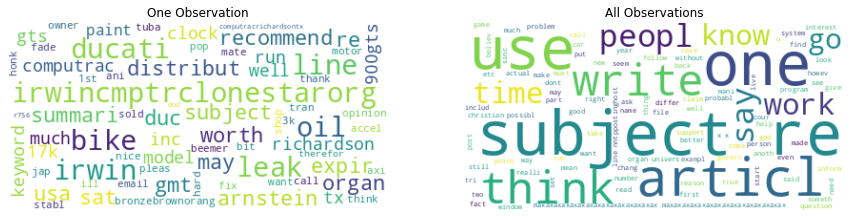

In [193]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.title('One Observation')

plt.subplot(1, 2, 2)    
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.title('All Observations')

plt.show()

### 9.0. Creating Features with Transactional & Time-Series Data